<a href="https://colab.research.google.com/github/anders-graffe/experimentos/blob/main/Series_BTC_ETH_SPX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ccxt
!pip install arch
!pip install pycausalimpact


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.7/288.7 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import math

#Modelos y test
import statsmodels.tsa.stattools as sts
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from arch import arch_model

#Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Métricas
from sklearn.metrics import mean_squared_error
from causalimpact import CausalImpact

#Gráficos y tablas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose


#Datos financieros
import ccxt, yfinance as yf
sns.set()


## **Fuente de datos**


---

Se emplea para el informe la serie de precios en dólares USD del Bitcoin, de Ethereum y del S&P500 desde Yahoo Finance.

In [ ]:

# Obtener datos de activos con yfinance
df = yf.download(['^GSPC','BTC-USD' ,'ETH-USD'], start='2018-01-01', progress=False)
df = df['Close']
df.rename(columns={'^GSPC': 'spx',
                   'BTC-USD' : 'btc',
                   'ETH-USD': 'eth'}, inplace=True)
df.tail()

,btc,eth,spx
Date,,,
2023-11-29,37858.492188,2029.929199,4550.580078
2023-11-30,37712.746094,2052.556152,4567.799805
2023-12-01,38688.750000,2087.139893,4594.629883
2023-12-02,39476.332031,2165.704102,NaN
2023-12-04,40782.843750,2216.484863,NaN


## **Preprocesamiento**



### **Imputación de valores faltantes**




In [ ]:
df = df.asfreq(freq='b')
fecha_inicio = pd.to_datetime('2018-01-01')
fecha_fin = pd.to_datetime('2023-11-16')

# Seleccionar las filas dentro del rango de fechas en el DataFrame df
df = df.loc[(df.index >= fecha_inicio)]# & (df.index <= fecha_fin)]

df.fillna(method='ffill', inplace=True)
df = df.dropna()
df.tail()

,btc,eth,spx
Date,,,
2023-11-28,37831.085938,2049.338135,4554.890137
2023-11-29,37858.492188,2029.929199,4550.580078
2023-11-30,37712.746094,2052.556152,4567.799805
2023-12-01,38688.750000,2087.139893,4594.629883
2023-12-04,40782.843750,2216.484863,4594.629883


### **Verificar NAs**

In [ ]:
df = df.asfreq('b')
df.isna().sum()

btc    0
eth    0
spx    0
dtype: int64


## **Series de precios vs. retornos**


---

Asumiendo que el activo no paga dividendos, su tenencia por un período de tiempo, desde ${t-1}$ hasta  $t$, producirá un retorno simple definido como:
\begin{align}
       R_t\ =\ \frac{\ P_t}{P_{t-1}}\ -\ 1\ =\ \ \frac{P_t-\ P_{t-1}}{P_{t-1}}\
    \end{align}

\
Sobre este periodo de tiempo se define el log-retorno $(r_t)$, mediante la expresión:

\
\begin{align}
r_t = ln(R_t + 1) = ln(P_t) − ln(P_(t-1))
   \end{align}

\
Obsérvese que la serie de los log-retornos, que llamaremos la serie de los retornos, no tiene unidades, es estable en la media y facilita el cálculo de un retorno compuesto k períodos desde el tiempo $t[k]$ hasta el tiempo $t$. Así:

\
\begin{align}r_t[k]= ln\left(1\ +\ R_t\left[k\right]\right)=\ r_t\ +r_{t+1}\ +\ ...\ +\ r_{t+k}   \end{align}



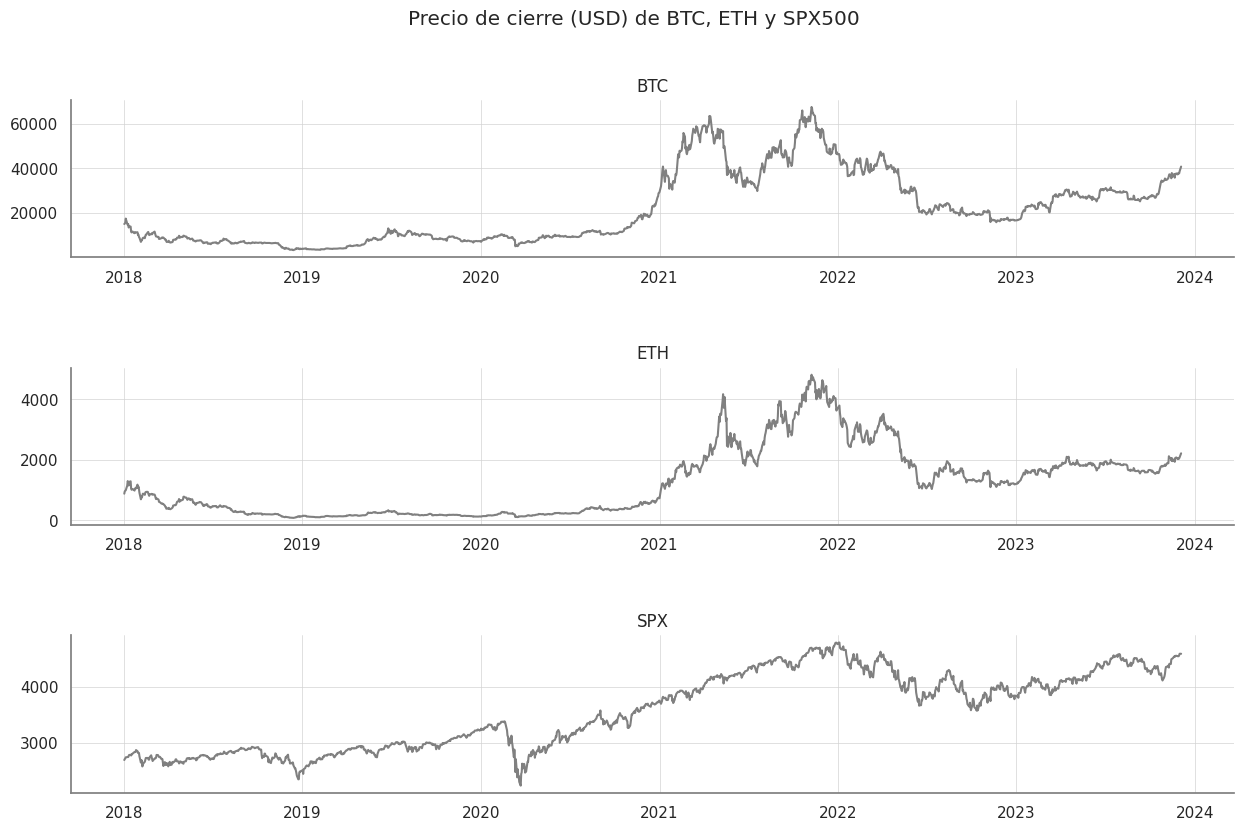

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 9), sharey=False)

# Graficar las series en cada uno de los subgráficos
for i, (col, color) in enumerate(zip(['btc', 'eth', 'spx'], ['gray', 'gray', 'gray'])):
    axs[i].plot(df.index, df[col], label=col.upper(), color=color)
    axs[i].set_title(col.upper())
    axs[i].grid(color='lightgray', linestyle='-', linewidth=0.5)
    axs[i].spines[['top', 'right']].set_visible(False)
    axs[i].spines[['bottom', 'left']].set_color('gray')
    axs[i].set_facecolor('white')

plt.subplots_adjust(hspace=0.7)
plt.suptitle('Precio de cierre (USD) de BTC, ETH y SPX500')
plt.show()


La varianza es igual a los retornos al cuadrado  $\sigma^2 = r_t^{2}$ y la volatilidad se define como desviación típica, que en este caso será, $\sigma = abs(r_t)$

Ahora creamos los retornos, los retornos acumulados y la variable target con los retornos del futuro a usar en el modelo de machine learning

In [ ]:
for col in df.columns:
    df[f'returns_{col}'] = np.log(df[col]).diff().mul(100)
    df[f'returns_cumsum_{col}'] = df[f'returns_{col}'].cumsum()
    df[f'target1_{col}'] = df[f'returns_{col}'].shift(-1)
    df[f'target2_{col}'] = df[f'returns_{col}'].shift(-2)

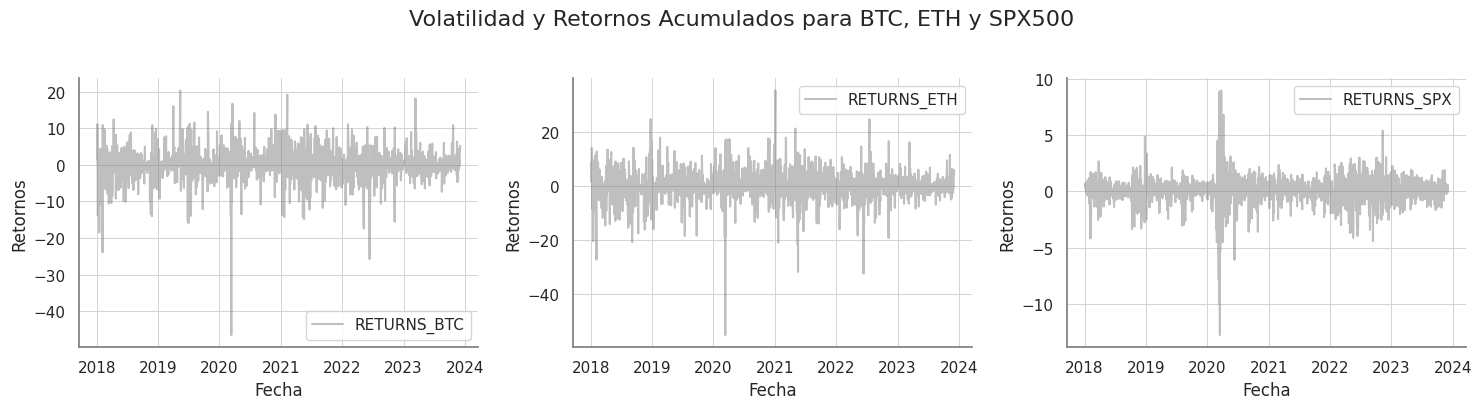

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)


# retornos
for i, col in enumerate(['returns_btc', 'returns_eth', 'returns_spx']):
    axs[i].plot(df.index, df[col], label=col.upper(), color='gray', alpha=0.5)
    axs[i].grid(color='lightgray', linestyle='-', linewidth=0.7)
    axs[i].spines[['top', 'right']].set_visible(False)
    axs[i].spines[['bottom', 'left']].set_color('gray')
    axs[i].set_facecolor('white')
    axs[i].set_ylabel('Retornos')
    axs[i].set_xlabel('Fecha')
    axs[i].legend()


plt.subplots_adjust(hspace=0.7)
plt.suptitle('Volatilidad y Retornos Acumulados para BTC, ETH y SPX500', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

 >Gráficamente se observa como en los retornos diarios de estos tres activos existen clústeres de volatilidad  muy marcados en su comportamiento, un clúster no es otra cosa que la desviación estándar, es decir la dispersión que hay de cada una de las observaciones con respecto de la media (González, 2020). Conforme mayor dispersión por ende habrá una mayor volatilidad, por ejemplo, al inicio de la pandemia de Covid-19 alrededor de abril 2020 vemos un clúster que se repite en las tres series, luego entre febrero 2022 y julio 2022 se observa en SPX una volatilidad inusual en el comportamiento del precio de cierre.

 >Otra característica observable en la figura 2 es el Leverage effect : la volatilidad es mayor con una caída de la variable que con subidas.




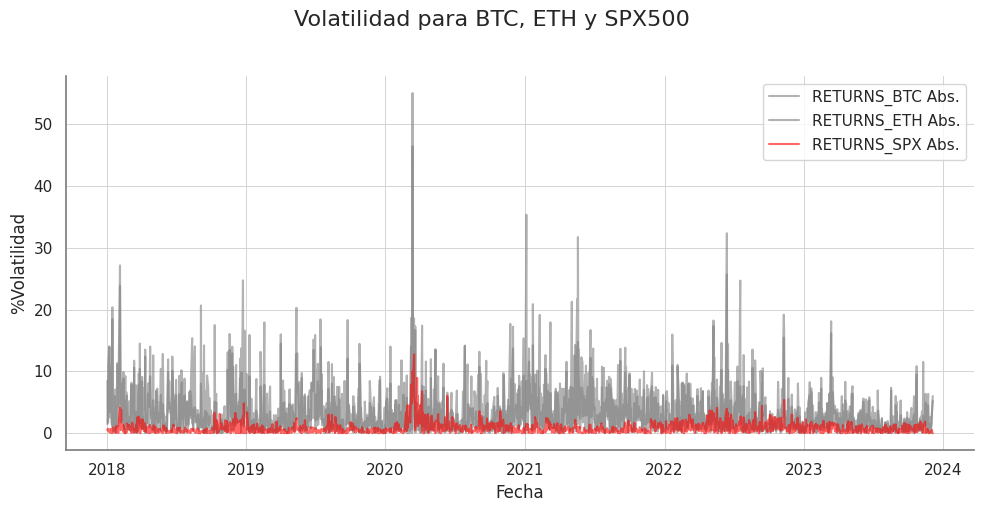

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5))

# Graficar retornos absolutos
for col in ['returns_btc', 'returns_eth', 'returns_spx']:
  color = 'red' if col == 'returns_spx' else 'gray'
  axs.plot(df.index, df[col].abs(), label=f'{col.upper()} Abs.', alpha=0.6, color=color)

axs.grid(color='lightgray', linestyle='-', linewidth=0.7)
axs.spines[['top', 'right']].set_visible(False)
axs.spines[['bottom', 'left']].set_color('gray')
axs.set_facecolor('white')
axs.set_ylabel('%Volatilidad')
axs.set_xlabel('Fecha')
axs.legend()

plt.suptitle('Volatilidad para BTC, ETH y SPX500', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
activos = ['btc', 'eth', 'spx']
data = []

for activo in activos:
    vol_dia = df[f'returns_{activo}'].std()
    ratio = vol_dia / df['returns_spx'].std()
    vol_mes = math.sqrt(21) * vol_dia
    vol_anual = math.sqrt(252) * vol_dia

    data.append([activo.upper(), vol_dia, vol_mes, vol_anual, ratio])

headers = ['Activo', 'Volatilidad Diaria %', 'Volatilidad Mensual %', 'Volatilidad Anual %', 'Ratio']
resumen = pd.DataFrame(data, columns=headers)
resumen


,Activo,Volatilidad Diaria %,Volatilidad Mensual %,Volatilidad Anual %,Ratio
0,BTC,4.354007,19.952567,69.117718,3.374431
1,ETH,5.667283,25.970753,89.965327,4.392242
2,SPX,1.290294,5.912869,20.482780,1.000000


## **Algunos modelos para estimación de la volatilidad**

### **Modelo VAR**

El modelo VAR (Vector AutoRegressive) es un modelo estadístico utilizado para analizar la relación entre múltiples series de tiempo. Es especialmente útil cuando se trata de modelar y comprender las interacciones entre variables económicas o financieras que evolucionan juntas en el tiempo. Los modelos VAR pueden servir a la hora de estimar los retornos de SPX en función de las interacciones con el mercado BTC y ETH, respondiendo a tipos de preguntas, tales como:

* **Análisis de impacto:**¿Cuál es el impacto que tuvo la caída de las criptomonedas y el aumento de su volatilidad en un cambio sorpresivo de 1% en SPX?
* **Pronóstico:** De ser real el impacto ¿Existe alguna posibilidad que el efecto de las criptomonedas sobre SPX se mantenga en el tiempo?
* **Descripción de los datos:** ¿La volatilidad en el mercado de las criptomonedas ayuda a explicar las perturbaciones en los mercados tradicionales?


> #### **Train y Test**





In [ ]:
start_date= '2023-01-01'
train = df[:start_date][['returns_btc', 'returns_eth', 'returns_spx']].dropna()
test = df[start_date:][['returns_btc', 'returns_eth', 'returns_spx']].dropna()



> #### **Test de estacionariedad**

Una de los requisitos del modelo VAR es que las series sean estacionarias para ello se usa el test DF aumentado, tal que:

*   $H_0$: La serie tiene raiz unitaria y por lo tanto no es estacionaria
*   $H_1$:La serie no tiene raiz unitaria y por lo tanto es estacionaria



In [ ]:
adf_results = pd.DataFrame(columns=['Activo', 'Valor p'])

for i in train:
    adf_test = sm.tsa.adfuller(train[[i]], maxlag=None, autolag='AIC')
    adf_results = adf_results.append({'Activo': i, 'Valor p': adf_test[1]}, ignore_index=True)

adf_results

<ipython-input-139-7ba3ff236dbd>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adf_results = adf_results.append({'Activo': i, 'Valor p': adf_test[1]}, ignore_index=True)
<ipython-input-139-7ba3ff236dbd>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adf_results = adf_results.append({'Activo': i, 'Valor p': adf_test[1]}, ignore_index=True)
<ipython-input-139-7ba3ff236dbd>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adf_results = adf_results.append({'Activo': i, 'Valor p': adf_test[1]}, ignore_index=True)


,Activo,Valor p
0,returns_btc,5.545337e-29
1,returns_eth,0.000000e+00
2,returns_spx,2.119019e-19


Todas las series tienen un Valor p < 0.05 por lo tanto son estacionarias  y se pueden aplicar al VAR

> #### **Identificación del orden modelo**

Se identifica la cantidad de rezagos con lo que se puede modelar el VAR, el criterio usado es el AIC

In [ ]:
model = VAR(train)
modelsel = model.select_order(10)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,5.957,5.969*,386.3,5.961
1,5.936,5.984,378.4,5.954*
2,5.930,6.014,376.2,5.961
3,5.931,6.051,376.5,5.976
4,5.935,6.090,377.9,5.993
5,5.924,6.115,373.8,5.996
6,5.907,6.135,367.7,5.993
7,5.900,6.164,365.0,5.999
8,5.894,6.194,363.0,6.007
9,5.881*,6.217,358.2*,6.007


> #### **Matriz de causalidad de Granger**

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15

def grangers_causality_matrix(data, variables, max_lag=3):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r, c]], max_lag, verbose=False)
            p_values = [test_result[i + 1][0]['ssr_ftest'][1] for i in range(max_lag)]
            min_p_value = np.min(p_values)
            dataset.loc[r, c] = min_p_value

    dataset.columns = [col + '_x' for col in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset

# Example usage
grangers_causality_matrix(train, variables=train.columns)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print resul

,returns_btc_x,returns_eth_x,returns_spx_x
returns_btc_y,1.000000,0.072957,0.349281
returns_eth_y,0.004914,1.000000,0.233463
returns_spx_y,0.014094,0.013782,1.000000


Vemos como en el caso del SPX no existe una relacion causal bidireccional, ya que BTC y ETH explican a SPX pero SPX no logra explicar en el tiempo a BTC y ETH

> #### **Selección: VAR(9)**

In [ ]:
res = model.fit(maxlags=9, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Dec, 2023
Time:                     03:17:11
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    6.22471
Nobs:                     1294.00    HQIC:                   6.01523
Log likelihood:          -9234.75    FPE:                    361.191
AIC:                      5.88939    Det(Omega_mle):         338.724
--------------------------------------------------------------------
Results for equation returns_btc
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.013175         0.125750            0.105           0.917
L1.returns_btc         0.005647         0.050422            0.112           0.911
L1.returns_eth        -0.019374         0.038276  

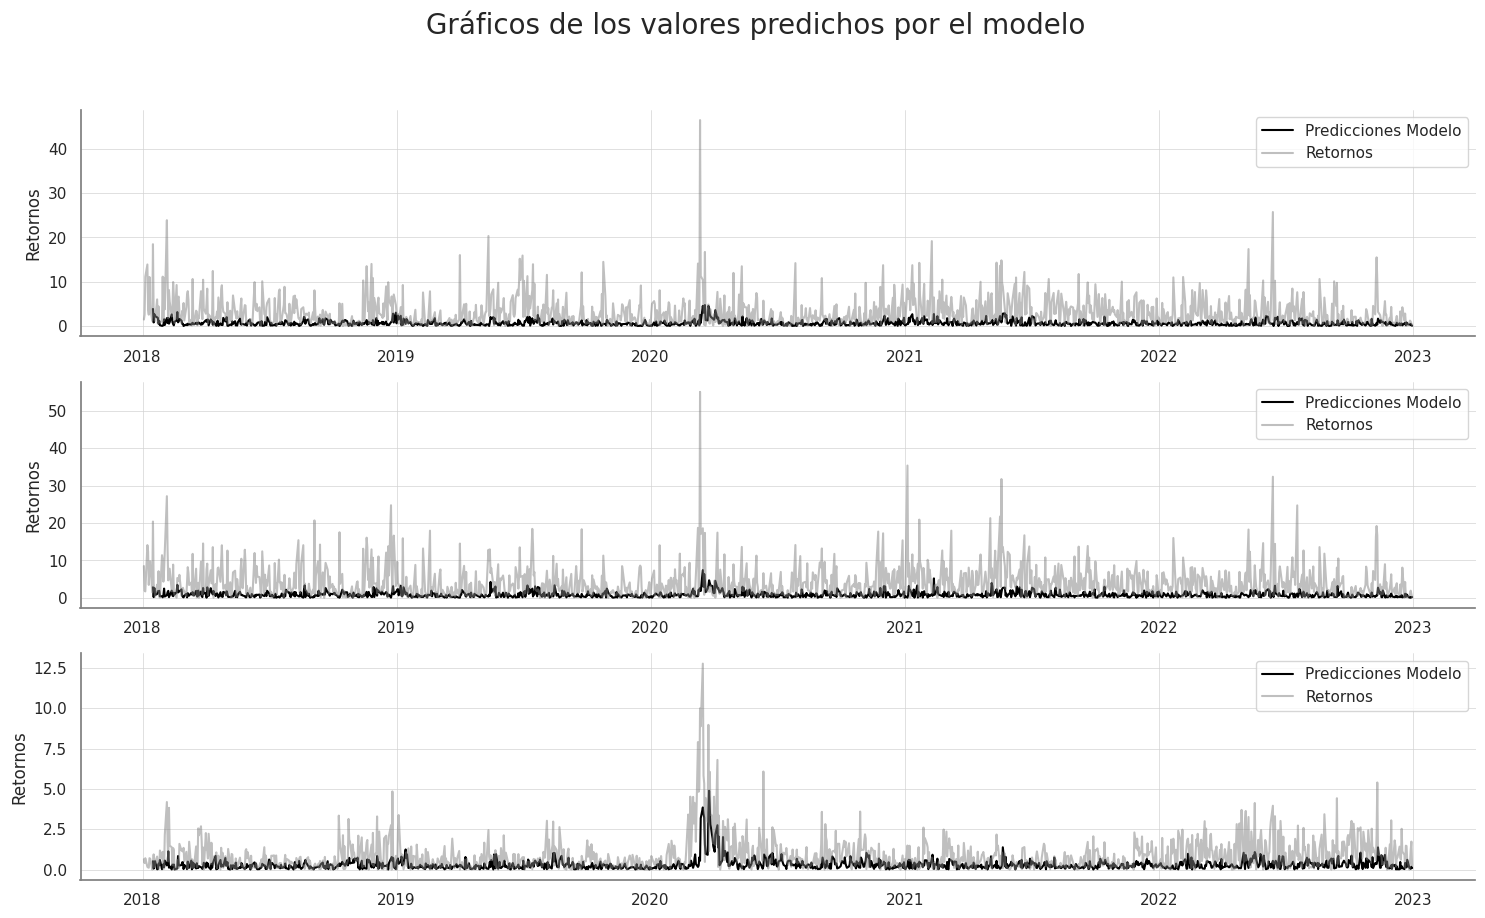

In [ ]:
y_fitted = res.fittedvalues

fig, axs = plt.subplots(3)
fig.suptitle('Gráficos de los valores predichos por el modelo', fontsize=20)
fig.set_size_inches(18, 10)

# Configurar gráficos
for i in range(3):
    axs[i].plot(y_fitted.iloc[:, i].abs(), color='black', label='Predicciones Modelo')
    axs[i].plot(df[:start_date][['returns_btc', 'returns_eth', 'returns_spx']].abs().dropna().iloc[:, i],
                color='gray', linestyle='-', label='Retornos' ,alpha=0.5)

    # Configuración de estilo
    axs[i].set_facecolor('white')
    axs[i].grid(color='lightgray', linestyle='-', linewidth=0.5)
    axs[i].spines[['top', 'right']].set_visible(False)
    axs[i].spines[['bottom', 'left']].set_color('gray')
    axs[i].set_ylabel('Retornos')
    axs[i].legend()

plt.show()


#### **Impulso respuesta**

 * $ETH - BTC$: un aumento sorpresivo en los retornos de ETH debería hacer disminuir los retornos de BTC en el corto plazo. Por lo tanto, a mayor dominancia de retornos de ETH menor seran los retornos en BTC

* $SPX - BTC$: un aumento sorpresivo en los retornos de SPX no influye de manera importante en los retornos de BTC.

* $BTC - ETH$: un aumento sorpresivo en los retornos de BTC parecieran tener un efecto negativo en los retornos de ETH.

* $SPX - ETH$: un aumento sorpresivo en los retornos de SPX no influye de manera importante en los retornos de BTC.

* $BTC - SPX$: un aumento sorpresivo en los retornos de BTC haria disminuir a los retornos de SPX.

* $ETH - SPX$: un shock en los retornos de ETH tiene un impacto positivo en los retornos de SPX.

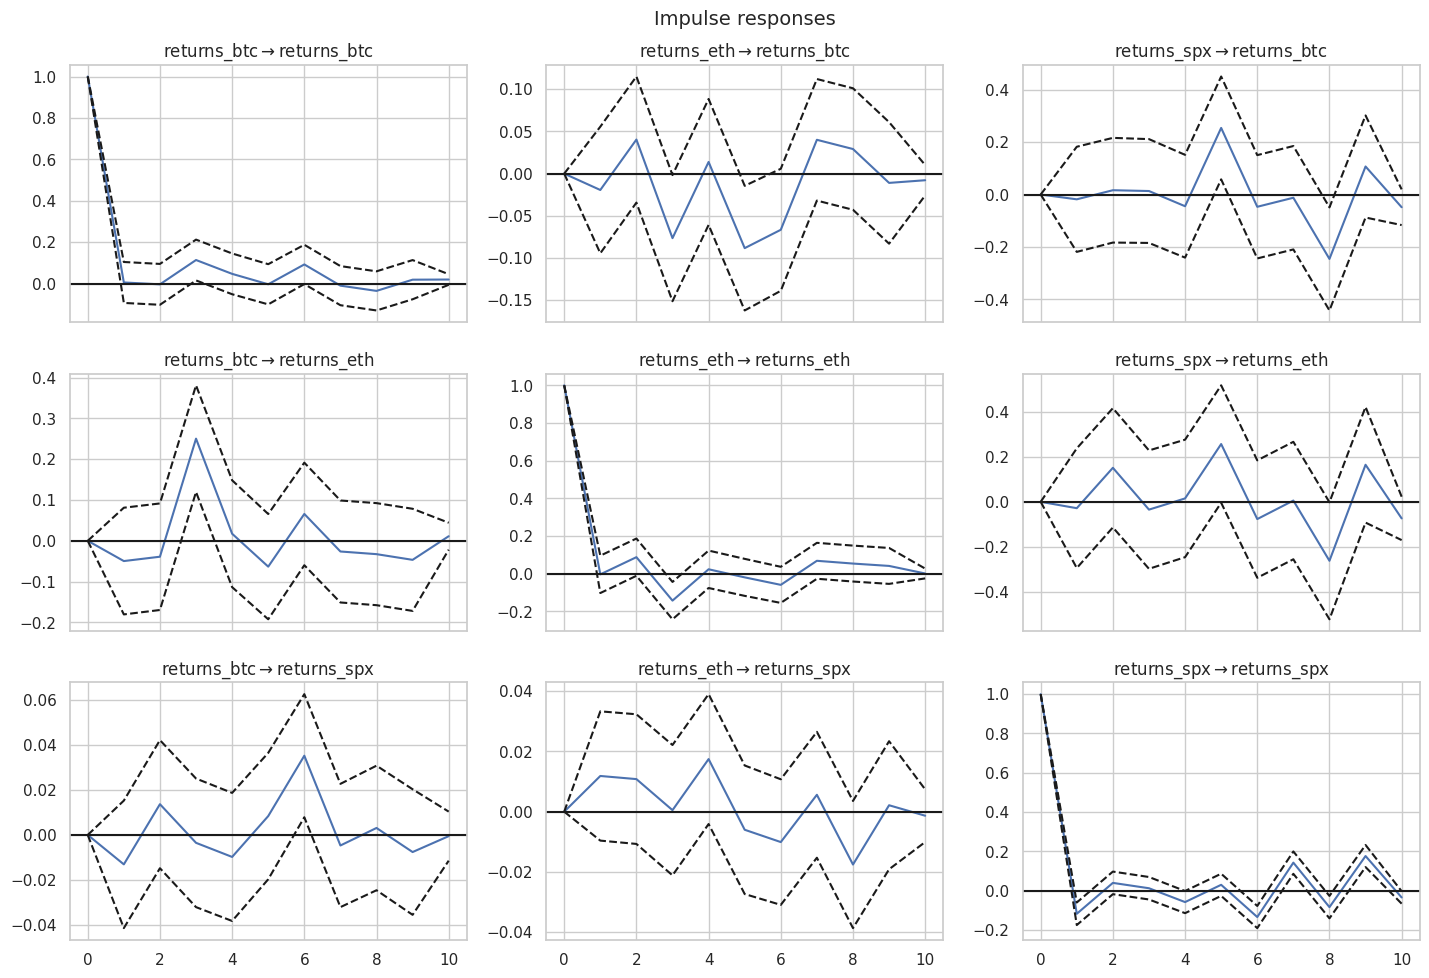

In [ ]:
irf = res.irf(10)
irf.plot(orth=False, figsize=(15,10))
plt.show()

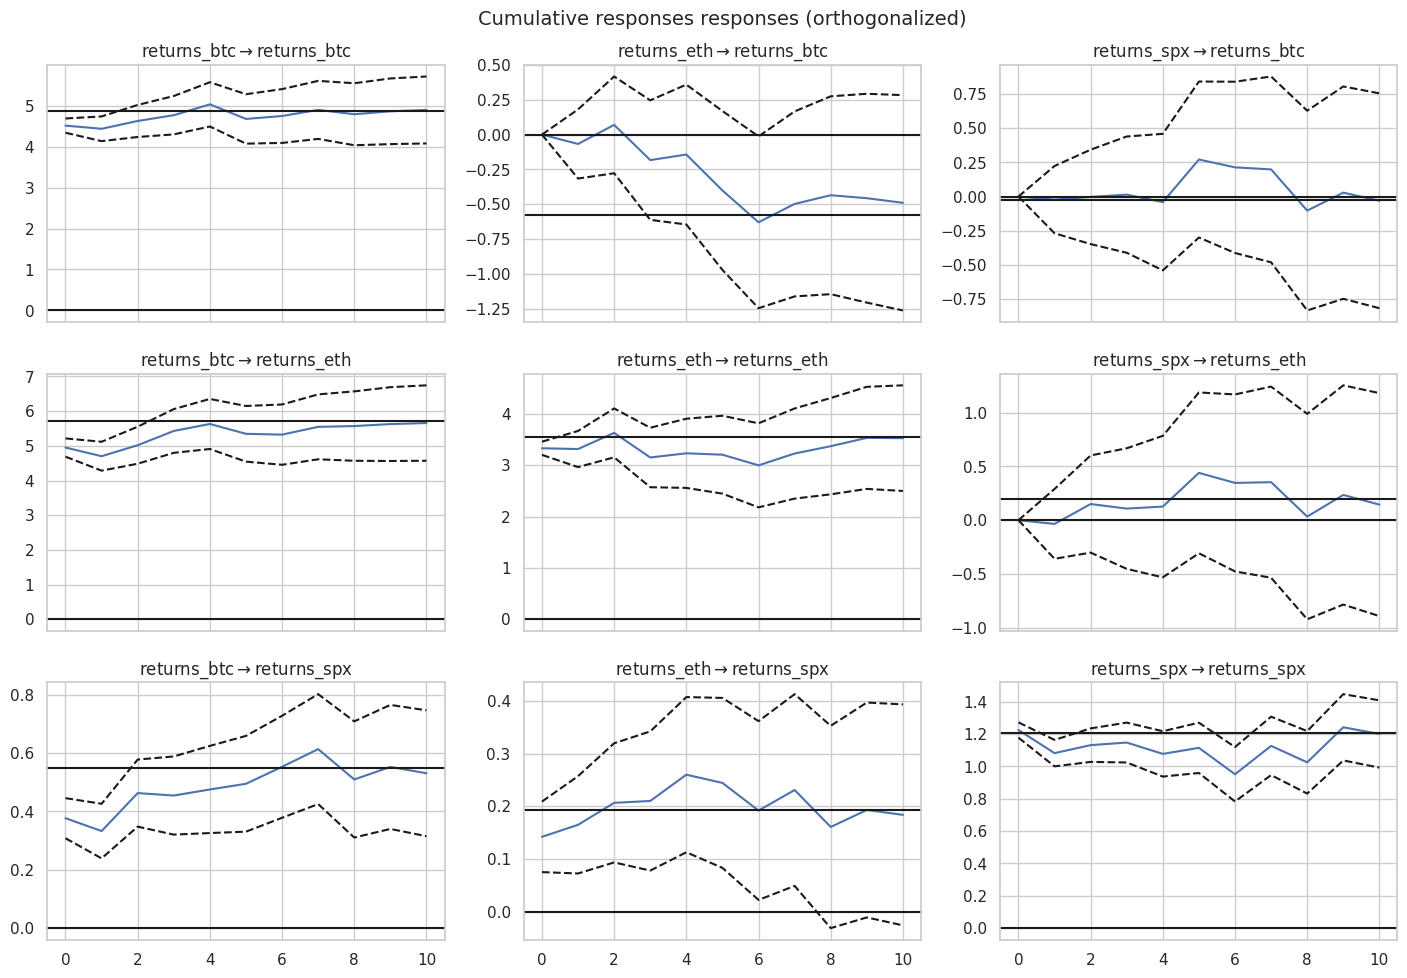

In [ ]:
irf = res.irf(10)
irf.plot_cum_effects(orth=True, figsize=(15,10))
plt.show()

In [ ]:
print(res.test_normality())

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 10825.857, critical value: 12.592>, p-value: 0.000>


>#### **Diagnostico de los residuos**

* *Estacionariedad*

In [ ]:
[sts.adfuller(res.resid.iloc[:,i])[1] for i in range(3)]

[0.0, 0.0, 0.0]

* *Autocorrelación*

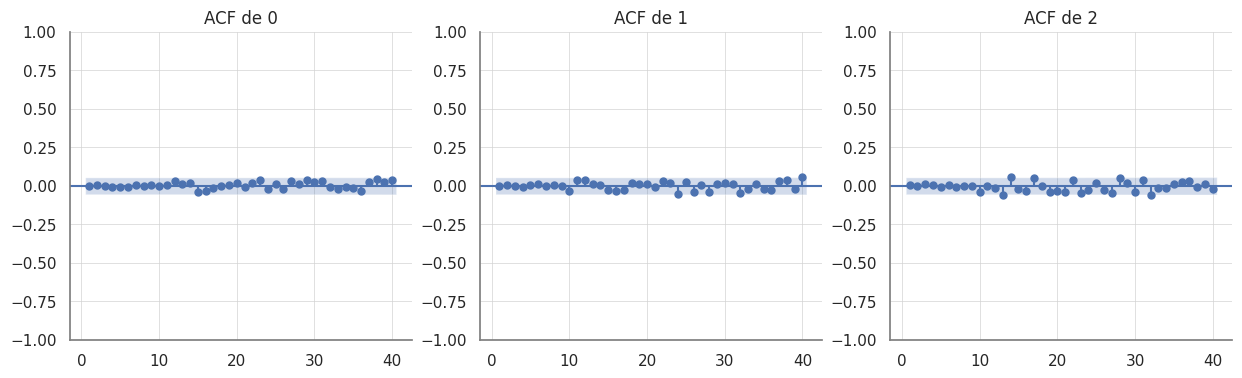

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), facecolor='white')

# Graficar los gráficos de autocorrelación
for i in range(3):
    sgt.plot_acf(res.resid.iloc[:, i], zero=False, lags=40, ax=axs[i])
    axs[i].set_facecolor('white')
    axs[i].grid(color='lightgray', linestyle='-', linewidth=0.5)
    axs[i].spines[['top', 'right']].set_visible(False)
    axs[i].spines[['bottom', 'left']].set_color('gray')
    axs[i].set_title(f'ACF de {i}')

plt.show()


* *Normalidad*

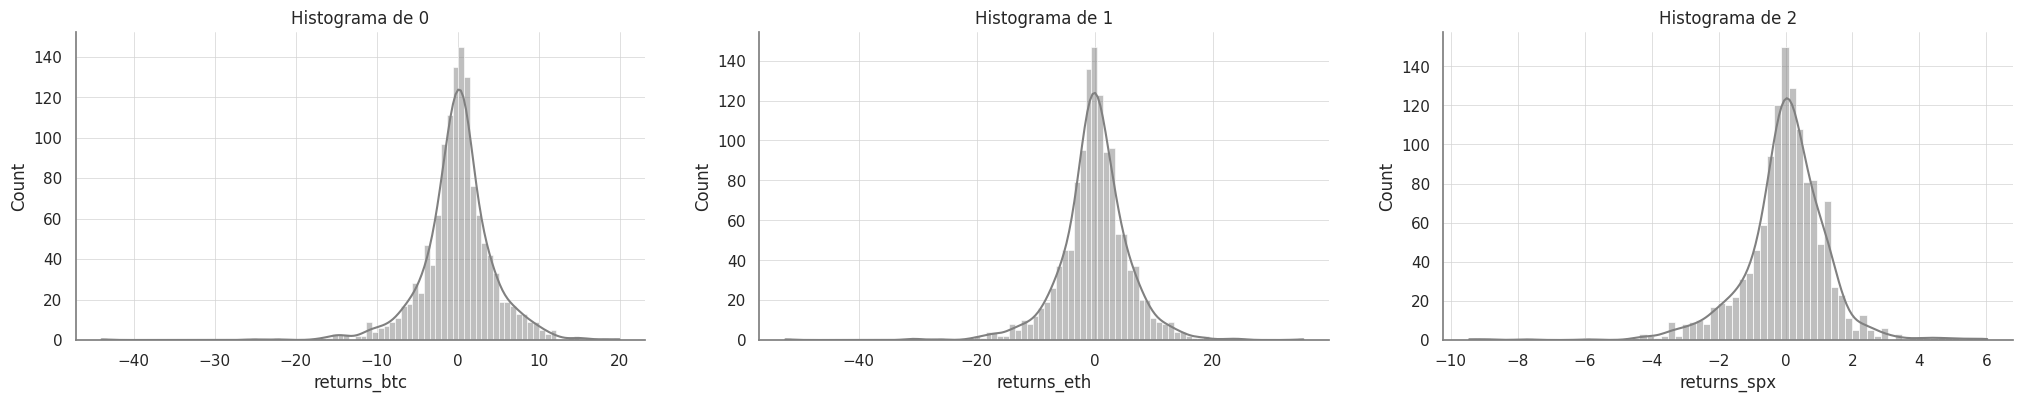

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(25, 4), facecolor='white')

# Graficar histogramas con curva de densidad
for i in range(3):
    sns.histplot(res.resid.iloc[:, i], kde=True, ax=axs[i], color='gray')
    axs[i].set_facecolor('white')
    axs[i].grid(color='lightgray', linestyle='-', linewidth=0.5)
    axs[i].spines[['top', 'right']].set_visible(False)
    axs[i].spines[['bottom', 'left']].set_color('gray')
    axs[i].set_title(f'Histograma de {i}')

plt.show()


#### **Pronóstico**

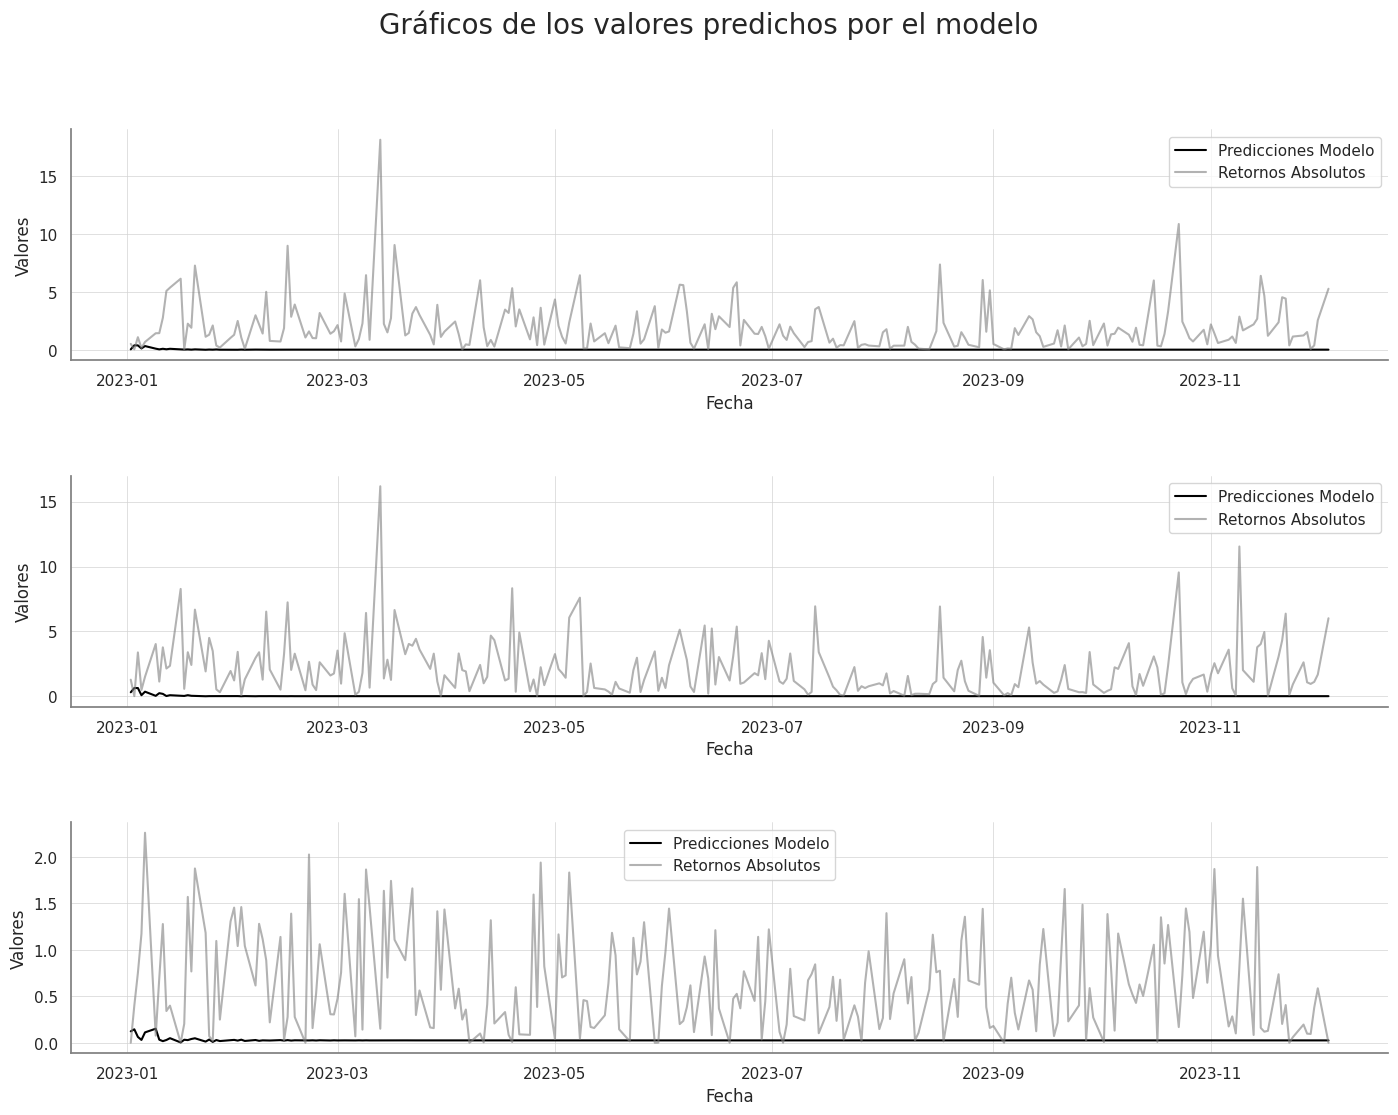

In [ ]:
pred = res.forecast(y=test.values, steps=len(test))
pred = pd.DataFrame(pred, index=test.index, columns=test.columns + '_pred')


fig, axs = plt.subplots(3)
fig.suptitle('Gráficos de los valores predichos por el modelo', fontsize=20)
fig.set_size_inches(17, 12)

# Configurar gráficos
for i in range(3):
    axs[i].plot(pred.abs().iloc[:, i], color='black', label='Predicciones Modelo')
    axs[i].plot(test.abs().iloc[:, i],
                color='gray', linestyle='-', label='Retornos Absolutos',alpha=0.6)

    # Configuración de estilo
    axs[i].set_facecolor('white')
    axs[i].grid(color='lightgray', linestyle='-', linewidth=0.5)
    axs[i].spines[['top', 'right']].set_visible(False)
    axs[i].spines[['bottom', 'left']].set_color('gray')
    axs[i].set_ylabel('Valores')
    axs[i].set_xlabel('Fecha')
    axs[i].legend()
plt.subplots_adjust(hspace=0.5)
plt.show()

> #### **Métricas**

In [ ]:
test = test.abs()

RMSE_btc = mean_squared_error(test['returns_btc'].rolling(22).std().dropna(), pred['returns_btc_pred'].rolling(22).std().dropna(), squared=False)
RMSE_eth = mean_squared_error(test['returns_eth'].rolling(22).std().dropna(), pred['returns_eth_pred'].rolling(22).std().dropna(), squared=False)
RMSE_spx = mean_squared_error(test['returns_spx'].rolling(22).std().dropna(), pred['returns_spx_pred'].rolling(22).std().dropna(), squared=False)


# Crear un DataFrame con los resultados
resultados = pd.DataFrame({
    'Activo': ['BTC', 'ETH', 'SPX'],
    'RMSE': [RMSE_btc, RMSE_eth, RMSE_spx]
})

print(resultados)

  Activo      RMSE
0    BTC  2.080927
1    ETH  2.105765
2    SPX  0.509682


### **Modelos GARCH**

#### **Autocorrelación de los $r_t^{2}$**

Se analiza el correlograma de estos residuos y, a partir de
ellos se identifica los órdenes p y q de un modelo GARCH. Habitualmente si
el correlograma tiene una estructura de un AR(p) se plantea un modelo
ARCH(p); en otro caso se plantea un modelo GARCH(1,1) que es el más
simple

Se muestra las autocorrelaciones de los retornos $r_t$ y $r_t^{2}$ y como los retornos no están correlacionados, mientras que $r_t^{2}$ tiene autocorrelaciones descritas por un proceso $AR(p)$ con coeficiente autorregresivo positivos.




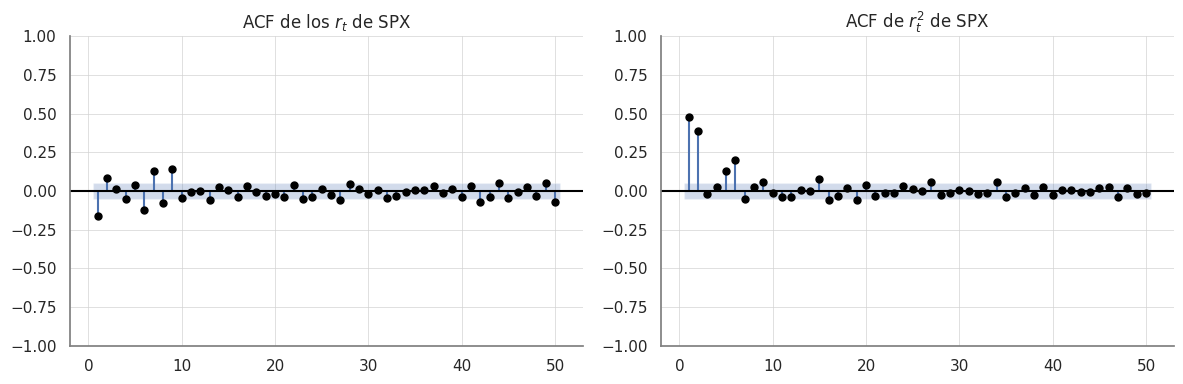

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Gráfico de PACF
sgt.plot_pacf(df['returns_spx'].iloc[1:], zero=False, lags=50, ax=axes[0], color='black')
axes[0].set_facecolor('white')
axes[0].grid(color='lightgray', linestyle='-', linewidth=0.5)
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].spines[['bottom', 'left']].set_color('gray')
axes[0].set_facecolor('white')
axes[0].set_title('ACF de los $r_t$ de SPX')

# Gráfico de ACF para valores positivos
sgt.plot_pacf(df['returns_spx'].mul(df['returns_spx']).iloc[1:], zero=False, lags=50, ax=axes[1], color='black')
axes[1].set_facecolor('white')
axes[1].grid(color='lightgray', linestyle='-', linewidth=0.5)
axes[1].spines[['top', 'right']].set_visible(False)
axes[1].spines[['bottom', 'left']].set_color('gray')
axes[1].set_facecolor('white')
axes[1].set_title('ACF de $r_t^{2}$ de SPX')

# Ajustar diseño general
plt.tight_layout()
plt.show()




#### **GARCH (1,1) para BTC, ETH y S&P500**

In [ ]:
garch_spx = arch_model(df.returns_spx[1:],  vol = "EGARCH",p=1, q=1, dist = "t", mean='constant')
res_garch_spx = garch_spx.fit( last_obs = start_date, update_freq =10)
pred_garch_spx = res_garch_spx.forecast(horizon = 1, align = 'target')


garch_btc = arch_model(df.returns_btc[1:],  p=1, q=1, vol = 'EGARCH', dist = 't', mean='constant')
res_garch_btc = garch_btc.fit( last_obs = start_date, update_freq =10, disp = 'off')
pred_garch_btc = res_garch_btc.forecast(horizon = 1, align = 'target')


garch_eth = arch_model(df.returns_eth[1:],p=1, q=1, vol = 'EGARCH', dist = 't', mean='constant')
res_garch_eth = garch_eth.fit( last_obs = start_date, update_freq =10, disp = 'off')
pred_garch_eth = res_garch_eth.forecast(horizon = 1, align = 'target')

res_garch_spx,res_garch_btc, res_garch_eth

Iteration:     10,   Func. Count:     77,   Neg. LLF: 1845.2193896180345
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1845.2193792385258
            Iterations: 12
            Function evaluations: 89
            Gradient evaluations: 12


(                        Constant Mean - EGARCH Model Results                        
 Dep. Variable:                  returns_spx   R-squared:                       0.000
 Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                           EGARCH   Log-Likelihood:               -1845.22
 Distribution:      Standardized Student's t   AIC:                           3700.44
 Method:                  Maximum Likelihood   BIC:                           3726.30
                                               No. Observations:                 1303
 Date:                      Mon, Dec 04 2023   Df Residuals:                     1302
 Time:                              03:19:08   Df Model:                            1
                                 Mean Model                                
                  coef    std err          t      P>|t|    95.0% Conf. Int.
 -------------------------------------------------------------------------

* $mu:$ Es el rendimiento promedio diario a “Largo plazo”. Según el modelo, el SPX tenderá a un rendimiento diario del 0.16% en el largo plazo. Con un P-valor significativo menor a 5%.

* $omega:$ Es la varianza a largo plazo del retorno del SPX, en este caso alrededor del 4% (volatilidad). P-valor no significativo al 5%.

* $alpha 1:$ Es el impacto de la varianza cuadrada rezagada en el retorno de hoy. El rendimiento se explica un 28% por la volatilidad de hace un día. P-valor significativo.

* $beta 1:$ Es el impacto de los residuos cuadrados rezagados en el rendimiento y se explica un 71% por la varianza ajustada del día anterior. P-valor significativo.

In [ ]:
btc_param= pd.concat([res_garch_btc.params,res_garch_btc.pvalues], axis=1)
eth_param= pd.concat([res_garch_eth.params,res_garch_eth.pvalues], axis=1)
spx_param= pd.concat([res_garch_spx.params,res_garch_spx.pvalues], axis=1)

# Concatenar los DataFrames en uno solo
resultados_param = pd.concat([btc_param, eth_param, spx_param], axis=1, keys=['BTC', 'ETH', 'SPX'])

# Imprimir los resultados combinados
resultados_param


BTC                     ETH                      SPX  \
            params       pvalues    params        pvalues    params   
mu        0.044636  5.487766e-01  0.084759   4.631366e-01  0.114978   
omega     0.106495  1.595459e-02  0.316318   4.446637e-02  0.028815   
alpha[1]  0.237429  7.488961e-08  0.237962   3.819549e-04  0.379521   
beta[1]   0.983133  0.000000e+00  0.924580  1.104482e-119  0.966295   
nu        2.666630  1.443175e-31  3.058943   7.051874e-26  5.057561   

                        
               pvalues  
mu        7.047144e-09  
omega     2.648020e-02  
alpha[1]  1.301948e-14  
beta[1]   0.000000e+00  
nu        2.965904e-12

> **Predicciones sobre conjunto de train**

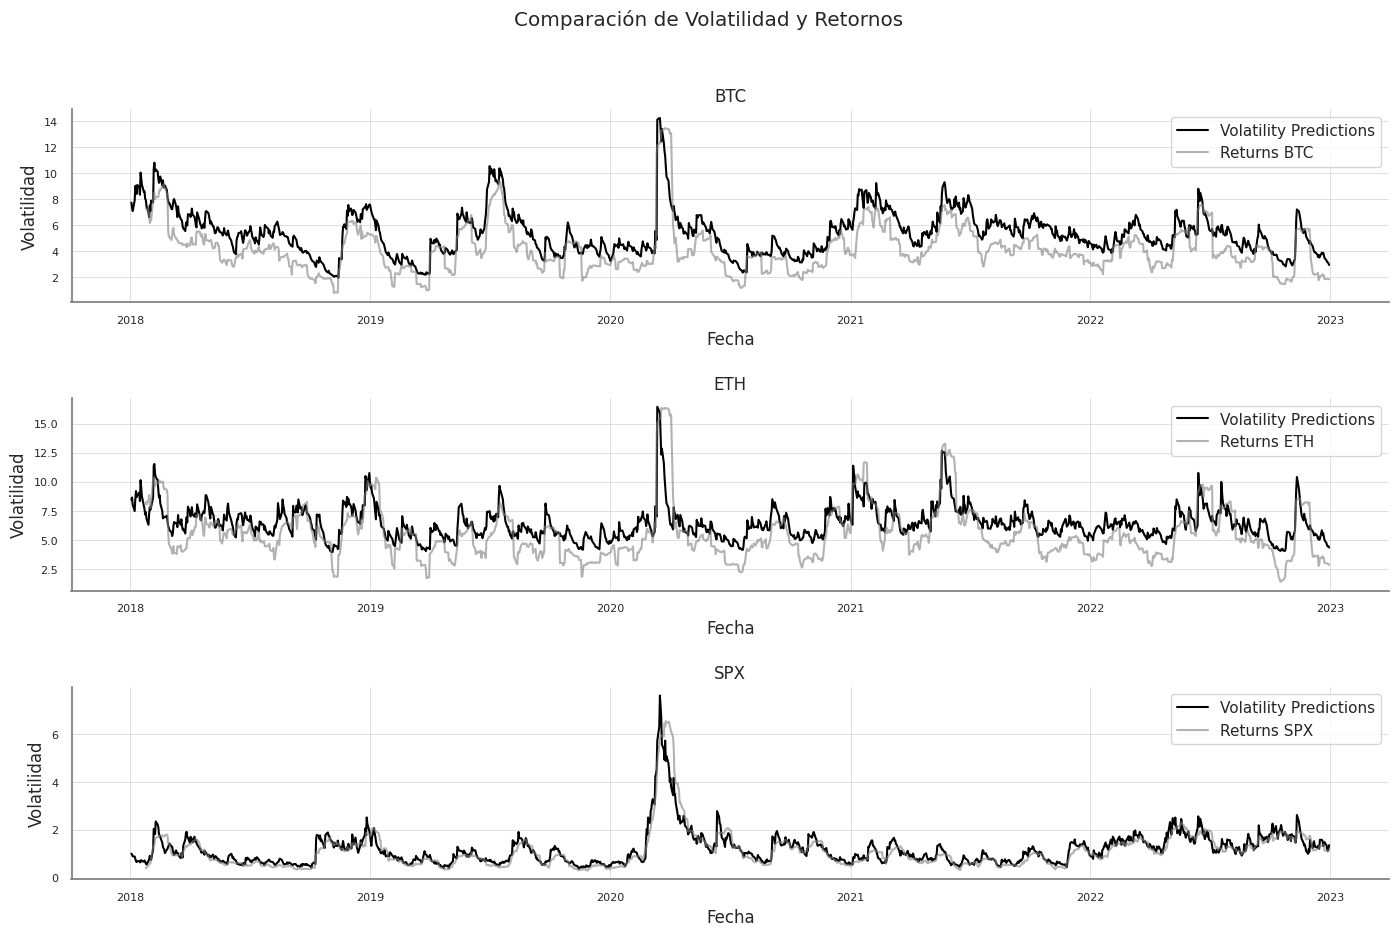

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(17, 10), sharey=False)

# Lista de predicciones y retornos correspondientes
predicciones = [res_garch_btc.conditional_volatility, res_garch_eth.conditional_volatility, res_garch_spx.conditional_volatility]
retornos = [df[:start_date]['returns_btc'].rolling(17).std(),
            df[:start_date]['returns_eth'].rolling(17).std(),
            df[:start_date]['returns_spx'].rolling(17).std()]

# Etiquetas para los títulos y colores
etiquetas = ['BTC', 'ETH', 'SPX']
colores = ['blue', 'red', 'green']

# Graficar las series en cada uno de los subgráficos
for i, (pred_garch, retornos, etiqueta, color) in enumerate(zip(predicciones, retornos, etiquetas, colores)):
    vol = pd.DataFrame(pred_garch)
    axs[i].plot(vol, color="black", label="Volatility Predictions")
    axs[i].plot(retornos.abs(), color="gray", alpha=0.6, label=f'Returns {etiqueta}')
    axs[i].set_title(etiqueta)  # Cambiar el título del subgráfico
    axs[i].grid(color='lightgray', linestyle='-', linewidth=0.5)
    axs[i].spines[['top', 'right']].set_visible(False)
    axs[i].spines[['bottom', 'left']].set_color('gray')
    axs[i].set_facecolor('white')  # Establecer el fondo del gráfico en blanco
    axs[i].set_ylabel('Volatilidad')  # Añadir etiqueta al eje y
    axs[i].set_xlabel('Fecha')  # Añadir etiqueta al eje y
    axs[i].tick_params( labelsize=8)
    axs[i].legend()  # Mostrar leyenda

    for label in axs[i].xaxis.get_ticklabels():
        label.set_fontsize(8)  # Ajustar el tamaño de la fuente


plt.suptitle('Comparación de Volatilidad y Retornos')  # Título general
plt.xlabel('Fecha')  # Etiqueta del eje x
plt.subplots_adjust(hspace=0.5)
plt.show()

#### **Diagnóstico de los residuos**

In [ ]:
spx_g = pd.DataFrame(res_garch_spx.std_resid).dropna()
btc_g = pd.DataFrame(res_garch_btc.std_resid).dropna()
eth_g = pd.DataFrame(res_garch_eth.std_resid).dropna()

# Concatenate the DataFrames
res_g = pd.concat([spx_g, btc_g, eth_g], axis=1,keys=['SPX', 'BTC', 'ETH'] )

# Assuming res_g contains the standardized residuals for SPX, BTC, and ETH

columnas_retornos = res_g.columns # Replace with the actual column names in res_g
estadisticas_retornos = pd.DataFrame(index=['Media', 'Mediana', 'Máximo', 'Mínimo', 'Desv. Est.', 'Asimetría', 'Curtosis'])

# Calcular y llenar las estadísticas
for columna in columnas_retornos:
    media = res_g[columna].mean()
    mediana = res_g[columna].median()
    maximo = res_g[columna].max()
    minimo = res_g[columna].min()
    desviacion_estandar = res_g[columna].std()
    asimetria = res_g[columna].skew()
    curtosis = res_g[columna].kurtosis()

    # Cambiar el nombre de las columnas
    if 'btc' in columna:
        nombre_columna = 'Retornos BTC'
    elif 'eth' in columna:
        nombre_columna = 'Retornos ETH'
    elif 'spx' in columna:
        nombre_columna = 'Retornos SPX'
    else:
        nombre_columna = f'Retornos {columna}'
    estadisticas_retornos[nombre_columna] = [media, mediana, maximo, minimo, desviacion_estandar, asimetria, curtosis]

estadisticas_retornos




,"Retornos ('SPX', 'std_resid')","Retornos ('BTC', 'std_resid')","Retornos ('ETH', 'std_resid')"
Media,-0.098446,-0.007868,-0.009898
Mediana,-0.064581,0.010256,-0.010220
Máximo,3.149545,6.942196,5.590095
Mínimo,-6.076973,-9.565006,-7.874915
Desv. Est.,0.988039,0.895938,0.925981
Asimetría,-0.854773,-0.765630,-0.532316
Curtosis,2.728851,17.175021,7.231466


> **Autocorrelación**

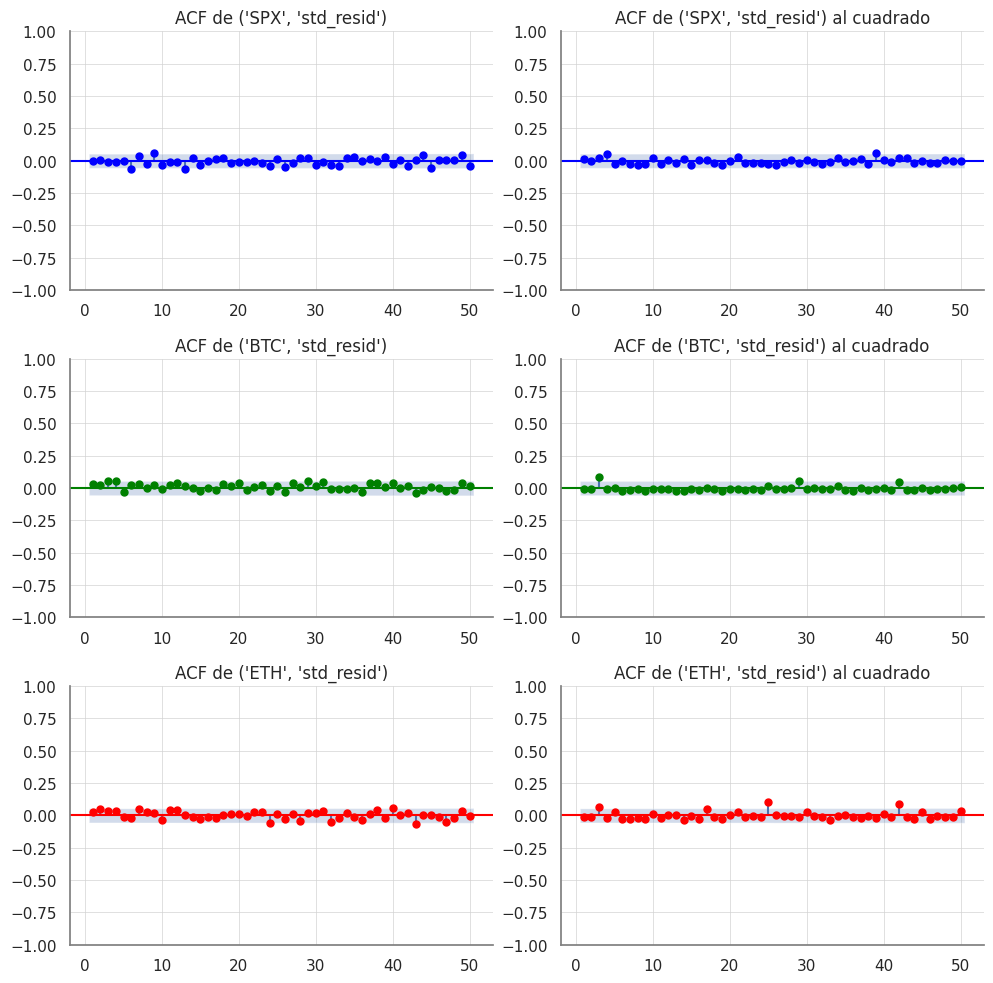

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
axes = axes.flatten()

for i, (col, color) in enumerate(zip(res_g.columns, ['blue', 'green', 'red'])):
    # Gráfico de ACF
    plot_acf(pd.DataFrame(res_g[col]), zero=False, lags=50, ax=axes[i*2], color=color)
    axes[i*2].set_facecolor('white')
    axes[i*2].grid(color='lightgray', linestyle='-', linewidth=0.5)
    axes[i*2].spines[['top', 'right']].set_visible(False)
    axes[i*2].spines[['bottom', 'left']].set_color('gray')
    axes[i*2].set_facecolor('white')
    axes[i*2].set_title(f'ACF de {col}')

    # Gráfico de ACF para valores positivos
    plot_acf(pd.DataFrame(res_g[col]**2), zero=False, lags=50, ax=axes[i*2+1], color=color)
    axes[i*2+1].set_facecolor('white')
    axes[i*2+1].grid(color='lightgray', linestyle='-', linewidth=0.5)
    axes[i*2+1].spines[['top', 'right']].set_visible(False)
    axes[i*2+1].spines[['bottom', 'left']].set_color('gray')
    axes[i*2+1].set_facecolor('white')
    axes[i*2+1].set_title(f'ACF de {col} al cuadrado')

plt.tight_layout()
plt.show()


> **Normalidad**

<ipython-input-160-935f3802e118>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.1, 0.1, 0.1, 1)). The keyword argument will take precedence.
  axs[i].plot(x, pdf, 'k', linewidth=2, label='Normal Density', color='orange')
<ipython-input-160-935f3802e118>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.1, 0.1, 0.1, 1)). The keyword argument will take precedence.
  axs[i].plot(x, pdf, 'k', linewidth=2, label='Normal Density', color='orange')
<ipython-input-160-935f3802e118>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.1, 0.1, 0.1, 1)). The keyword argument will take precedence.
  axs[i].plot(x, pdf, 'k', linewidth=2, label='Normal Density', color='orange')


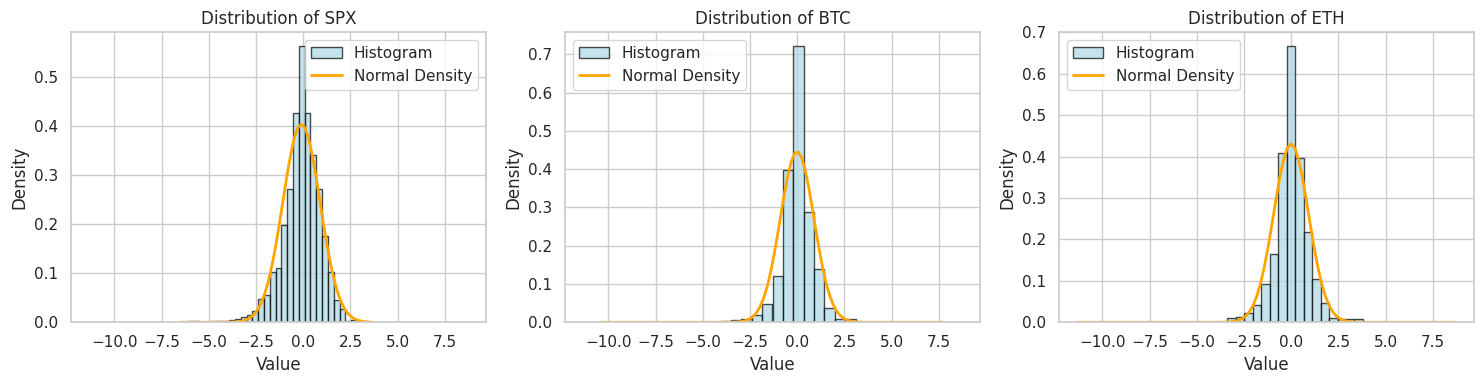

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Create a 3x1 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15,4), sharex=True)

# Iterate through each column in res_g
for i, col in enumerate(res_g.columns.levels[0]):
    # Extract the data for the current column
    data = res_g[col]

    # Plot the histogram
    axs[i].hist(data, bins=30, density=True, color='lightblue', edgecolor='black', alpha=0.7, label='Histogram')

    # Plot the normal density curve
    xmin, xmax = axs[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    pdf = norm.pdf(x, loc=data.mean(), scale=data.std())
    axs[i].plot(x, pdf, 'k', linewidth=2, label='Normal Density', color='orange')

    # Set labels and title for each subplot
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Density')
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()



#### **Pronóstico**

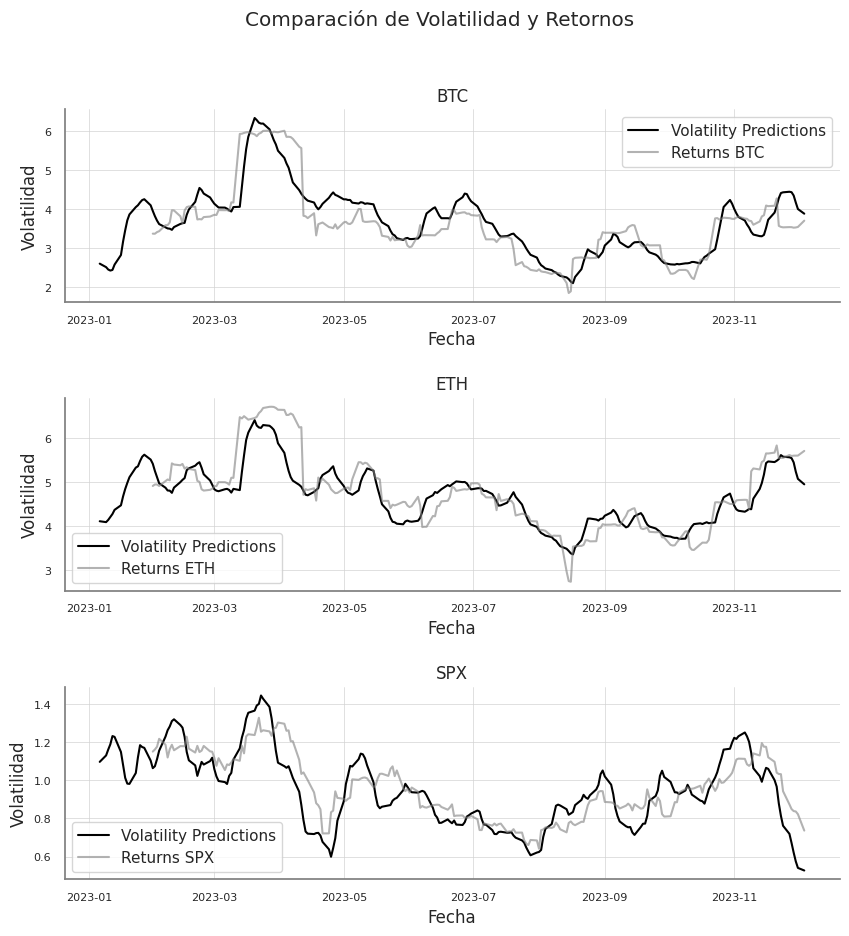

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=False)

# Lista de predicciones y retornos correspondientes
predicciones = [pred_garch_btc, pred_garch_eth, pred_garch_spx]
retornos = [df[start_date:]['returns_btc'].rolling(22).std()+0.9,
            df[start_date:]['returns_eth'].rolling(22).std()+1.87,
            df[start_date:]['returns_spx'].rolling(22).std()+0.15]

# Etiquetas para los títulos y colores
etiquetas = ['BTC', 'ETH', 'SPX']
colores = ['blue', 'red', 'green']

# Graficar las series en cada uno de los subgráficos
for i, (pred_garch, retornos, etiqueta, color) in enumerate(zip(predicciones, retornos, etiquetas, colores)):
    vol = pd.DataFrame(np.sqrt(pred_garch.residual_variance[start_date:]['h.1'])).rolling(5).mean()
    axs[i].plot(vol, color="black", label="Volatility Predictions")
    axs[i].plot(retornos.abs(), color="gray", alpha=0.6, label=f'Returns {etiqueta}')
    axs[i].set_title(etiqueta)  # Cambiar el título del subgráfico
    axs[i].grid(color='lightgray', linestyle='-', linewidth=0.5)
    axs[i].spines[['top', 'right']].set_visible(False)
    axs[i].spines[['bottom', 'left']].set_color('gray')
    axs[i].set_facecolor('white')  # Establecer el fondo del gráfico en blanco
    axs[i].set_ylabel('Volatilidad')  # Añadir etiqueta al eje y
    axs[i].set_xlabel('Fecha')  # Añadir etiqueta al eje y
    axs[i].tick_params( labelsize=8)
    axs[i].legend()  # Mostrar leyenda

    for label in axs[i].xaxis.get_ticklabels():
        label.set_fontsize(8)  # Ajustar el tamaño de la fuente


plt.suptitle('Comparación de Volatilidad y Retornos')  # Título general
plt.xlabel('Fecha')  # Etiqueta del eje x
plt.subplots_adjust(hspace=0.5)
plt.show()


#### **Métricas**

In [ ]:
test_btc = pd.concat([df[start_date:]['returns_btc'].rolling(22).std()+0.9, pred_garch_btc.residual_variance[start_date:]['h.1']**0.5], axis=1).dropna()
test_eth = pd.concat([df[start_date:]['returns_eth'].rolling(22).std()+1.83, pred_garch_eth.residual_variance[start_date:]['h.1']**0.5], axis=1).dropna()
test_spx = pd.concat([df[start_date:]['returns_spx'].rolling(22).std()+0.15, pred_garch_spx.residual_variance[start_date:]['h.1']**0.5], axis=1).dropna()

RMSE_btc = mean_squared_error(test_btc['returns_btc'], test_btc['h.1'], squared=False)
RMSE_eth = mean_squared_error(test_eth['returns_eth'], test_eth['h.1'], squared=False)
RMSE_spx = mean_squared_error(test_spx['returns_spx'], test_spx['h.1'], squared=False)


# Crear un DataFrame con los resultados
resultados = pd.DataFrame({
    'Activo': ['BTC', 'ETH', 'SPX'],
    'RMSE': [RMSE_btc, RMSE_eth, RMSE_spx]
})

resultados


,Activo,RMSE
0,BTC,0.457952
1,ETH,0.458055
2,SPX,0.153112


### **Modelo XGBoost**

#### **Feature Engeniering**

In [ ]:
def create_features(df, label=None):
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day

    #Lags retornos
    df['prev1']=df[label].shift(1)
    df['prev2']=df[label].shift(2)
    df['prev3']=df[label].shift(3)
    df['prev4']=df[label].shift(4)
    df['prev5']=df[label].shift(5)
    df['prev6']=df[label].shift(6)


    #Dif lags retornos

    df['delta1']= df['prev1'].diff()
    df['delta2']= df['prev2'].diff()
    df['delta3']= df['prev3'].diff()
    df['delta4']= df['prev4'].diff()
    df['delta5']= df['prev5'].diff()
    df['delta6']= df['prev6'].diff()

    #Derivadas
    df['deriva1'] = df['delta2']/df['delta1']
    df['deriva13'] = df['delta3']/ df['delta1']
    df['deriva2'] = df['delta3']/df['delta2']
    df['deriva3'] = df['delta4']/df['delta3']
    df['deriva4'] = df['delta5']/df['delta4']
    df['deriva5'] = df['delta6']/df['delta5']


    #Tendencias retornos
    df['tend1'] = df['prev1'].rolling(window=5,min_periods=4).mean()
    df['tend2'] = df['prev2'].rolling(window=5,min_periods=4).mean()
    df['tend3'] = df['prev3'].rolling(window=5,min_periods=4).mean()
    df['tend4'] = df['prev4'].rolling(window=5,min_periods=4).mean()
    df['tend5'] = df['prev5'].rolling(window=5,min_periods=4).mean()
    df['tend6'] = df['prev6'].rolling(window=5,min_periods=4).mean()


    #Tendencias retornos cumsum
    df['tend_cumsum_1'] = df[f'returns_cumsum_{label[-3:]}'].cumsum().rolling(window=3,min_periods=2).mean()
    df['tend_cumsum_2'] = df[f'returns_cumsum_{label[-3:]}'].cumsum().rolling(window=5,min_periods=4).mean()
    df['tend_cumsum_3'] = df[f'returns_cumsum_{label[-3:]}'].cumsum().rolling(window=10,min_periods=9).mean()
    df['tend_cumsum_4'] = df[f'returns_cumsum_{label[-3:]}'].cumsum().rolling(window=22,min_periods=2).mean()

     #std retornos
    df['tend_std_1'] = df[f'returns_{label[-3:]}'].rolling(window=3,min_periods=2).std()
    df['tend_std_2'] = df[f'returns_{label[-3:]}'].rolling(window=5,min_periods=4).std()
    df['tend_std_3'] = df[f'returns_{label[-3:]}'].rolling(window=10,min_periods=9).std()
    df['tend_std_3'] = df[f'returns_{label[-3:]}'].rolling(window=22,min_periods=21).std()

    #Tendencias precios
    df['tend1_pre'] = df[label[-3:]].rolling(window=3,min_periods=2).std()
    df['tend2_pre'] = df[label[-3:]].rolling(window=5,min_periods=2).std()
    df['tend3_pre'] = df[label[-3:]].rolling(window=10,min_periods=2).std()

    features = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
                'prev1','prev2','prev3','prev4','prev5','prev6',
                'delta1','delta2','delta3','delta4','delta5',
                'deriva1','deriva2','deriva3','deriva4','deriva5','deriva13',
                'tend1','tend2','tend3','tend4','tend5','tend6','tend1_pre','tend2_pre','tend3_pre',
                'tend_cumsum_1','tend_cumsum_2','tend_cumsum_3','tend_cumsum_4']
    X = df[features]

    if label:
        y = df[label]
        return X, y
    return X


#### **Division train y test**

In [ ]:
def create_train_test_sets(df, start_date, label):
    train_set = df[:start_date].dropna()
    test_set = df[start_date:]

    X_train, y_train = create_features(train_set, label=label)
    X_test, y_test = create_features(test_set, label=label)

    return X_train, y_train, X_test, y_test

X_train_btc, y_train_btc, X_test_btc, y_test_btc = create_train_test_sets(df, start_date, label="returns_btc")
X_train_eth, y_train_eth, X_test_eth, y_test_eth = create_train_test_sets(df, start_date, label="returns_eth")
X_train_spx, y_train_spx, X_test_spx, y_test_spx = create_train_test_sets(df, start_date, label="returns_spx")



<ipython-input-163-43e399a5d3f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
<ipython-input-163-43e399a5d3f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
<ipython-input-163-43e399a5d3f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

#### **Ajuste del modelo**

In [ ]:
from xgboost.callback import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, plot_tree
import xgboost as xgb

def train_xgboost_model(X_train, y_train, X_test, y_test, n_estimators=50, max_depth=3,max_leaves=256,verbose=False):
    reg = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth,max_leaves=max_leaves)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            verbose=verbose)

    return reg

reg_btc = train_xgboost_model(X_train_btc, y_train_btc, X_test_btc, y_test_btc, 100,3,256)
reg_eth = train_xgboost_model(X_train_eth, y_train_eth, X_test_eth, y_test_eth, 100,4,270)
reg_spx = train_xgboost_model(X_train_spx, y_train_spx, X_test_spx, y_test_spx,80,10,230)


#### **Importancia de variables**

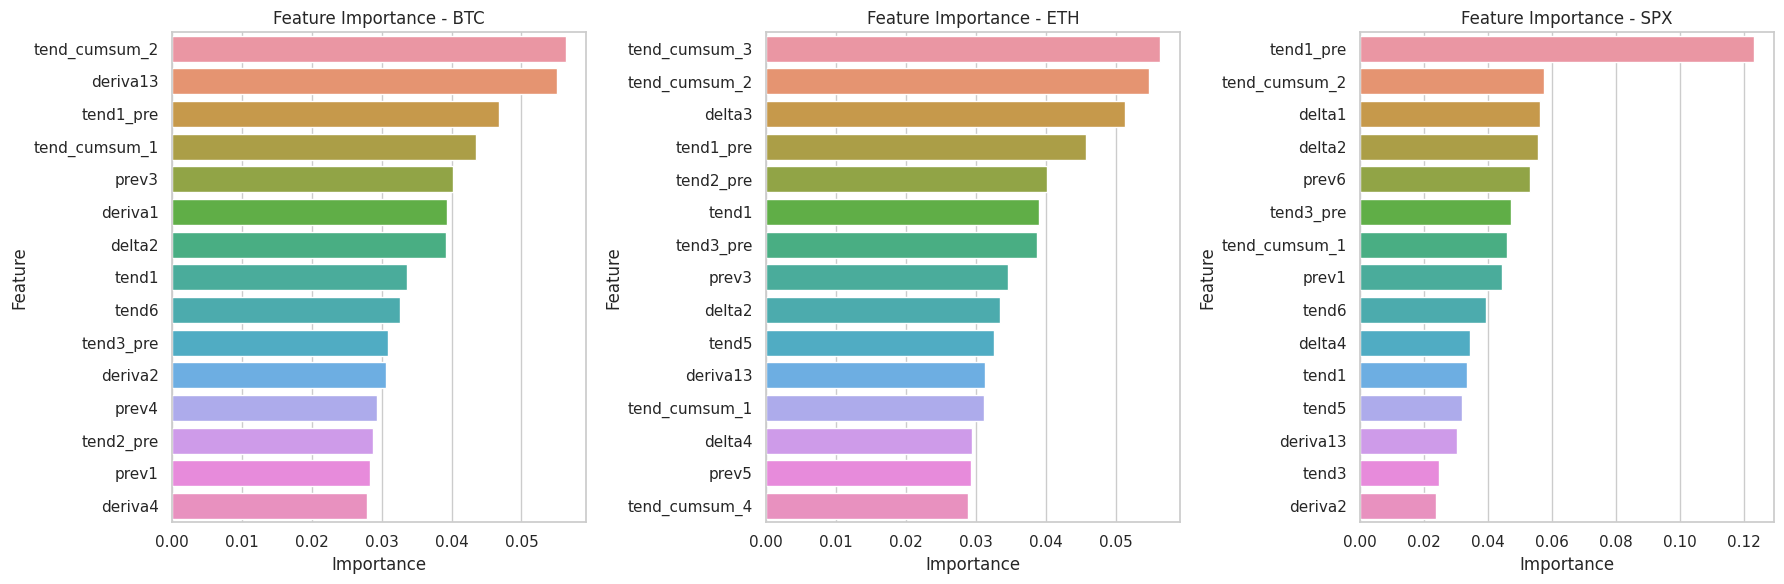

In [ ]:
def plot_feature_importance(model, X_train, ax, title="Feature Importance", top_n=15):
    feature_importance = model.feature_importances_
    feature_names = X_train.columns
    data={'Feature':feature_names,'Importance':feature_importance}
    fi_df = pd.DataFrame(data).sort_values(by='Importance', ascending=False)[:top_n]

    sns.barplot(x=fi_df['Importance'], y=fi_df['Feature'], ax=ax)
    ax.set_title(title)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_feature_importance(reg_btc, X_train_btc, ax=axes[0], title="Feature Importance - BTC")
plot_feature_importance(reg_eth, X_train_eth, ax=axes[1], title="Feature Importance - ETH")
plot_feature_importance(reg_spx, X_train_spx, ax=axes[2], title="Feature Importance - SPX")

plt.tight_layout()
plt.show()



#### **Pronóstico**

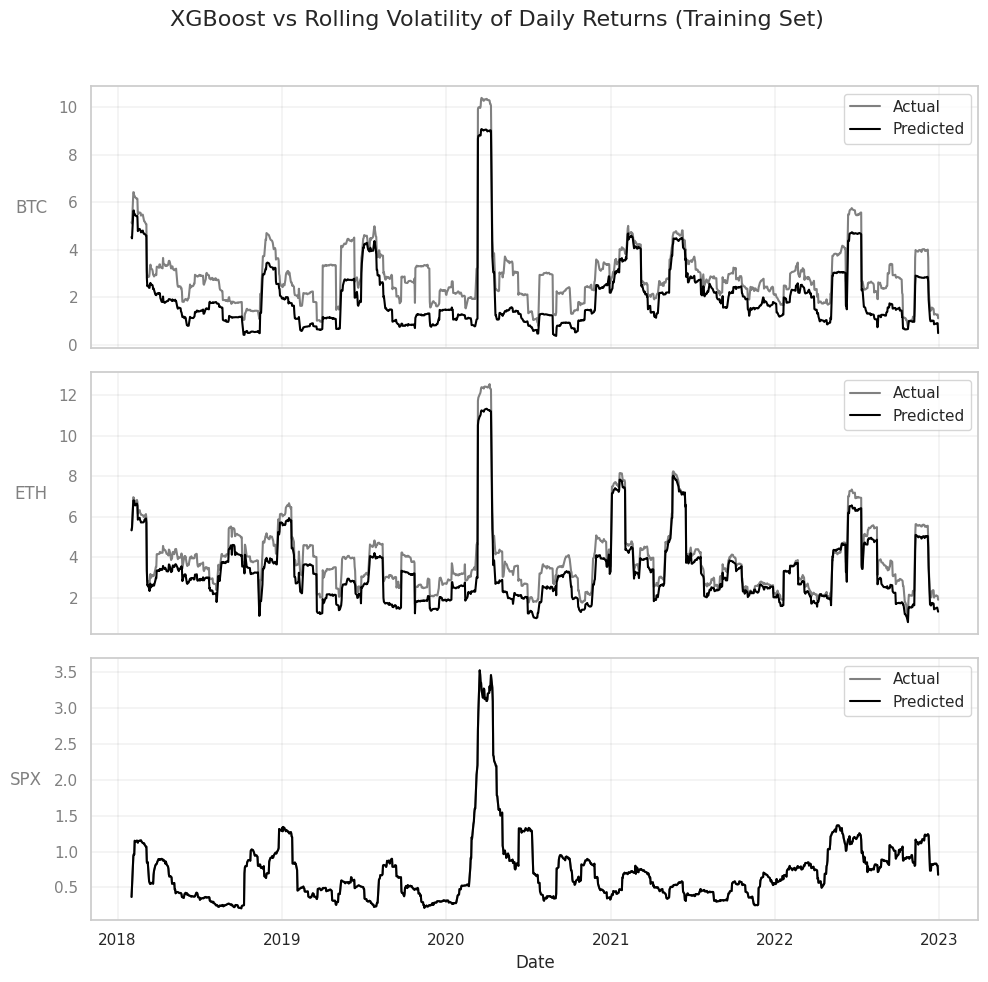

In [ ]:
def plot_predictions_matplotlib(actual_volatility, predicted_volatility, title):
    fig, axes = plt.subplots(nrows=3, ncols=1,  figsize=(10, 10), sharex=True)

    colors = ['gray', 'gray', 'gray']
    labels = ['BTC', 'ETH', 'SPX']

    for i, (actual, predicted, color, label) in enumerate(zip(actual_volatility.columns, predicted_volatility.columns, colors, labels)):
        axes[i].plot(actual_volatility.index, actual_volatility[actual], color=color, label='Actual')
        axes[i].plot(predicted_volatility.index, predicted_volatility[predicted], color='black', linestyle='-', label='Predicted')
        axes[i].set_facecolor('white')
        axes[i].grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5)
        axes[i].set_ylabel(label, rotation=0, labelpad=20, color=color)
        axes[i].tick_params(axis='y', colors=color)
        axes[i].legend()

    plt.xlabel('Date')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent clipping of suptitle
    plt.show()

# Crear un DataFrame con las predicciones para cada modelo
predictions_df = pd.DataFrame({
    'BTC_Actual': y_train_btc,
    'BTC_Predicted': reg_btc.predict(X_train_btc),
    'ETH_Actual': y_train_eth,
    'ETH_Predicted': reg_eth.predict(X_train_eth),
    'SPX_Actual': y_train_spx,
    'SPX_Predicted': reg_spx.predict(X_train_spx)
})

# Plotear las predicciones con Matplotlib
plot_predictions_matplotlib(predictions_df[['BTC_Actual', 'ETH_Actual', 'SPX_Actual']].abs().rolling(22).std(),
                            predictions_df[['BTC_Predicted', 'ETH_Predicted', 'SPX_Predicted']].abs().rolling(22).std(),
                            title='XGBoost vs Rolling Volatility of Daily Returns (Training Set)')


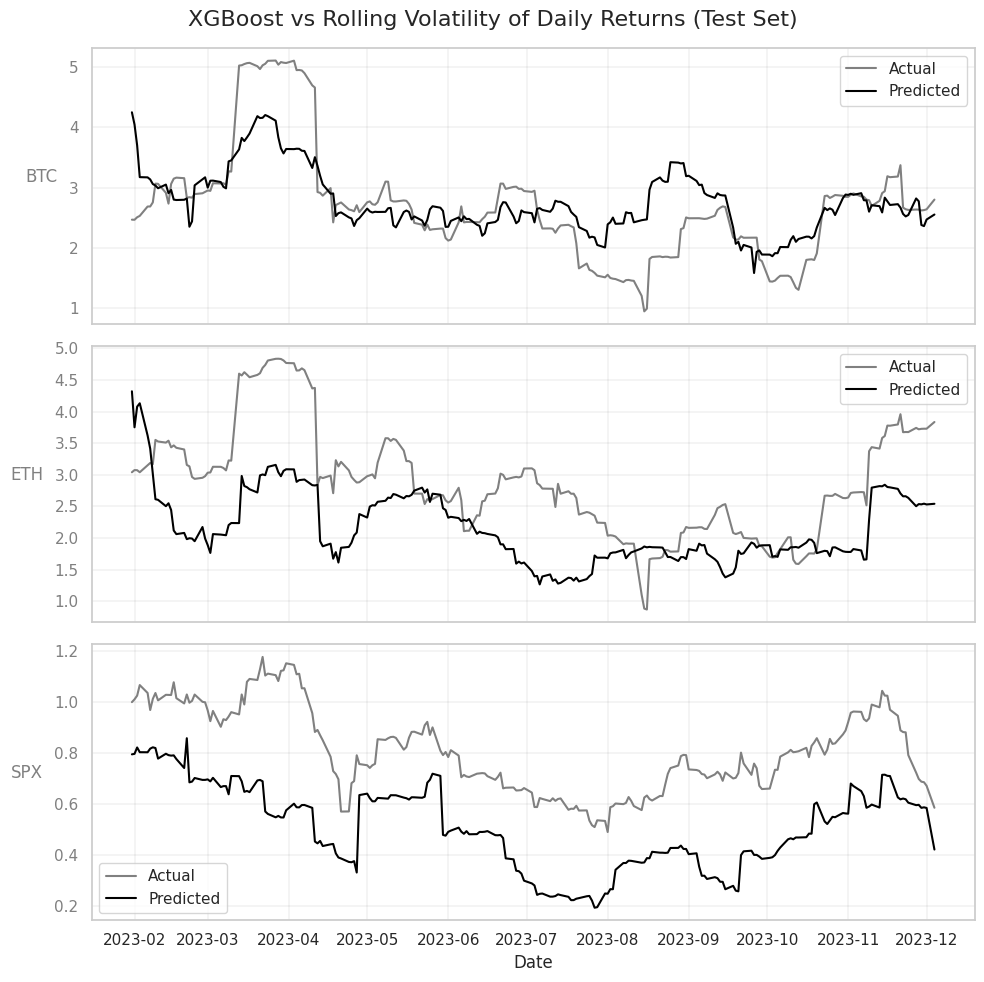

In [ ]:
def plot_predictions_test(actual_volatility, predicted_volatility, title):
    fig, axes = plt.subplots(nrows=3, ncols=1,  figsize=(10, 10), sharex=True)

    colors = ['gray', 'gray', 'gray']
    labels = ['BTC', 'ETH', 'SPX']

    for i, (actual, predicted, color, label) in enumerate(zip(actual_volatility.columns, predicted_volatility.columns, colors, labels)):
        axes[i].plot(actual_volatility.index, actual_volatility[actual], color=color, label='Actual')
        axes[i].plot(predicted_volatility.index, predicted_volatility[predicted], color='black', linestyle='-', label='Predicted')
        axes[i].set_facecolor('white')
        axes[i].grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5)
        axes[i].set_ylabel(label, rotation=0, labelpad=20, color=color)
        axes[i].tick_params(axis='y', colors=color)
        axes[i].legend()

    plt.xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(title, fontsize=16)
    plt.show()

# Crear un DataFrame con las predicciones para cada modelo en el conjunto de prueba
predictions_test_df = pd.DataFrame({
    'BTC_Actual': y_test_btc,
    'BTC_Predicted': reg_btc.predict(X_test_btc),
    'ETH_Actual': y_test_eth,
    'ETH_Predicted': reg_eth.predict(X_test_eth),
    'SPX_Actual': y_test_spx,
    'SPX_Predicted': reg_spx.predict(X_test_spx)
})

# Plotear las predicciones con Matplotlib para el conjunto de prueba
plot_predictions_test(predictions_test_df[['BTC_Actual', 'ETH_Actual', 'SPX_Actual']].rolling(22).std(),
                                 predictions_test_df[['BTC_Predicted', 'ETH_Predicted', 'SPX_Predicted']].rolling(22).std(),
                                 title='XGBoost vs Rolling Volatility of Daily Returns (Test Set)')


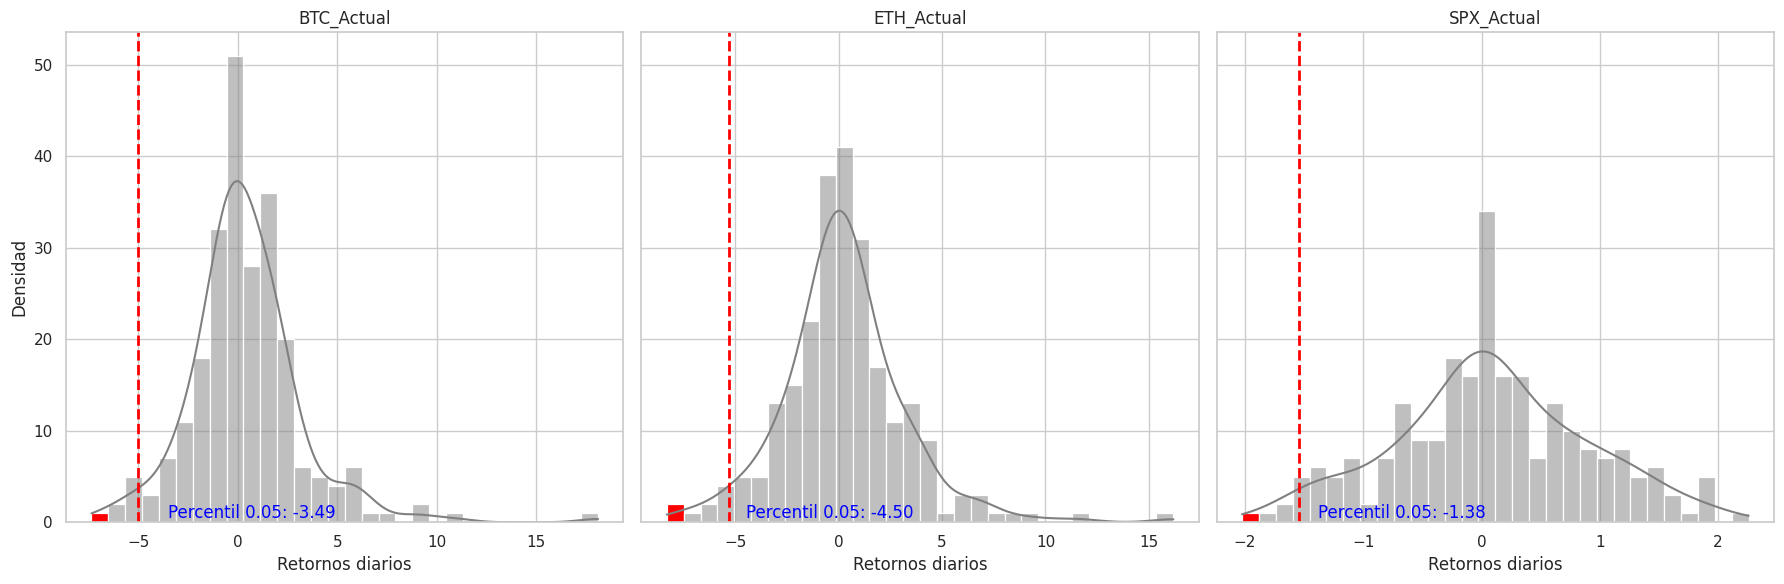

In [ ]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)
columnas = ['BTC_Actual', 'ETH_Actual', 'SPX_Actual']

for i, col in enumerate(columnas):
    # Histograma
    histplot = sns.histplot(predictions_test_df[col].dropna(), bins=30, color='gray', alpha=0.5, kde=True, ax=axes[i])

    # Calcular y marcar el intervalo de confianza del 95%
    lower_bound, upper_bound = np.percentile(predictions_test_df[col].dropna(), [2.5, 97.5])
    axes[i].axvline(x=lower_bound, color='red', linestyle='dashed', linewidth=2, label='95% CI (Lower)')

    # Mostrar el valor del percentil 0.05
    percentil_05 = np.percentile(predictions_test_df[col].dropna(), 5)
    axes[i].text(percentil_05, 0, f'Percentil 0.05: {percentil_05:.2f}', color='blue', ha='left', va='bottom')

    # Señalar barras con rendimientos negativos en rojo
    for patch in histplot.patches:
        if patch.get_x() <= np.min(predictions_test_df[col].dropna()) <= patch.get_x() + patch.get_width():
            patch.set_fc('red')

    # Añadir etiquetas
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Retornos diarios')
    axes[i].set_ylabel('Densidad')


plt.tight_layout()
plt.show()



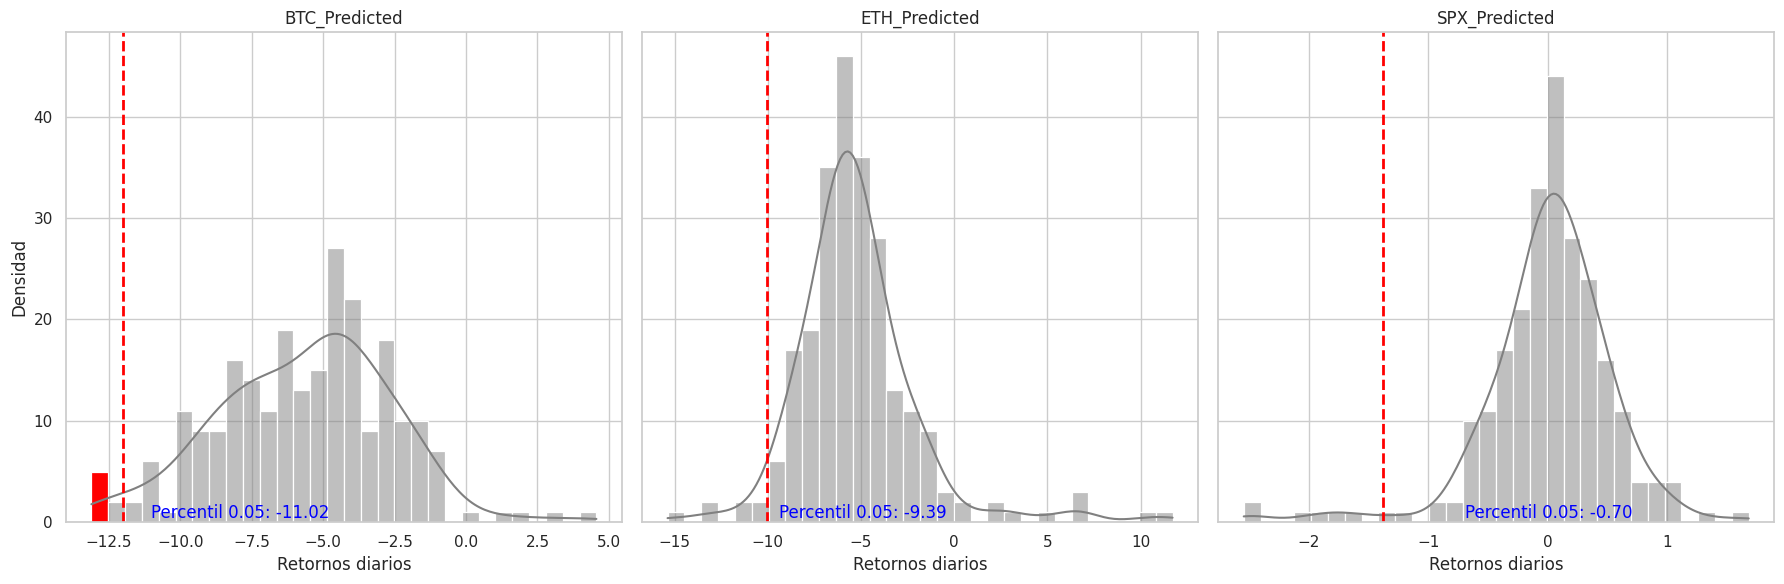

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)
columnas = ['BTC_Predicted', 'ETH_Predicted', 'SPX_Predicted']

for i, col in enumerate(columnas):
    # Histograma
    histplot = sns.histplot(predictions_test_df[col], bins=30, color='gray', alpha=0.5, kde=True, ax=axes[i])

    # Calcular y marcar el intervalo de confianza del 95%
    lower_bound, upper_bound = np.percentile(predictions_test_df[col], [2.5, 97.5])
    axes[i].axvline(x=lower_bound, color='red', linestyle='dashed', linewidth=2, label='95% CI (Lower)')

    # Mostrar el valor del percentil 0.05
    percentil_05 = np.percentile(predictions_test_df[col], 5)
    axes[i].text(percentil_05, 0, f'Percentil 0.05: {percentil_05:.2f}', color='blue', ha='left', va='bottom')

    # Señalar barras con rendimientos negativos en rojo
    for patch in histplot.patches:
        if patch.get_x() <= np.min(predictions_test_df[col]) <= patch.get_x() + patch.get_width():
            patch.set_fc('red')

    # Añadir etiquetas
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Retornos diarios')
    axes[i].set_ylabel('Densidad')


plt.tight_layout()
plt.show()


### **Resultados**

In [ ]:
from arch import arch_model
import numpy as np
import pandas as pd
import scipy.stats as st


n = len(predictions_test_df)
assets =['BTC_Predicted','ETH_Predicted','SPX_Predicted']

Risk_EG = {}
for i in assets:
    Risk_EG[i] = {'GARCH': []}

window = 10 * 1
alpha = 0.05
l = 0.94
s = 0

for j in assets:
    for i in range(window, n):
        X = predictions_test_df[j].iloc[i-window:i]
        z = st.norm.ppf(1 - alpha)
        mu, sigma = st.norm.fit(X)
        if i == window:
            s1 = sigma**2
        else:
            s1 = l * s1 + (1-l) * X[-2]**2

        #VaR_ewma = -st.norm.ppf(1-alpha) * np.sqrt(s1)

        am = arch_model(X, mean='Zero', vol='Garch',
                        p=1, o=0, q=1, dist='normal',
                        rescale=False)
        res = am.fit(update_freq=0, disp='off', show_warning=False)
        par = [res.params[0], res.params[1], res.params[2]]

        s2 = par[0] + par[1] * X[-2]**2 + par[2] * res.conditional_volatility[-1]**2
        VaR_garch = -np.sqrt(s2) * st.norm.ppf(1-alpha)

        Risk_EG[j]['GARCH'].append(VaR_garch)

for i in assets:
    Risk_EG[i] = pd.DataFrame(Risk_EG[i], index=predictions_test_df.index[window:])


In [ ]:
def calcular_riesgo(Risk_EG, activo):
    var = pd.concat([Risk_EG['BTC_Predicted']['GARCH'], Risk_EG['ETH_Predicted']['GARCH'], Risk_EG['SPX_Predicted']['GARCH']], axis=1, keys=['BTC', 'ETH', 'SPX'])

    riesgo = pd.concat([var[activo], predictions_test_df[f'{activo}_Actual']], axis=1).dropna()
    riesgo[activo]= predictions_test_df[f'{activo}_Predicted'] + predictions_test_df[f'{activo}_Predicted'].quantile(1-0.95)
    riesgo[activo]= predictions_test_df[f'{activo}_Predicted'] + predictions_test_df[f'{activo}_Predicted'].quantile(1-0.95)
    riesgo[activo]= predictions_test_df[f'{activo}_Predicted'] + predictions_test_df[f'{activo}_Predicted'].quantile(1-0.99)

    riesgo[f'excedidos_{activo}'] = riesgo.apply(lambda row: 1 if row[activo] > row[f'{activo}_Actual'] else 0, axis=1)

    return riesgo

riesgo = pd.concat([calcular_riesgo(Risk_EG, 'BTC'), calcular_riesgo(Risk_EG, 'ETH'),calcular_riesgo(Risk_EG, 'SPX')],axis=1)


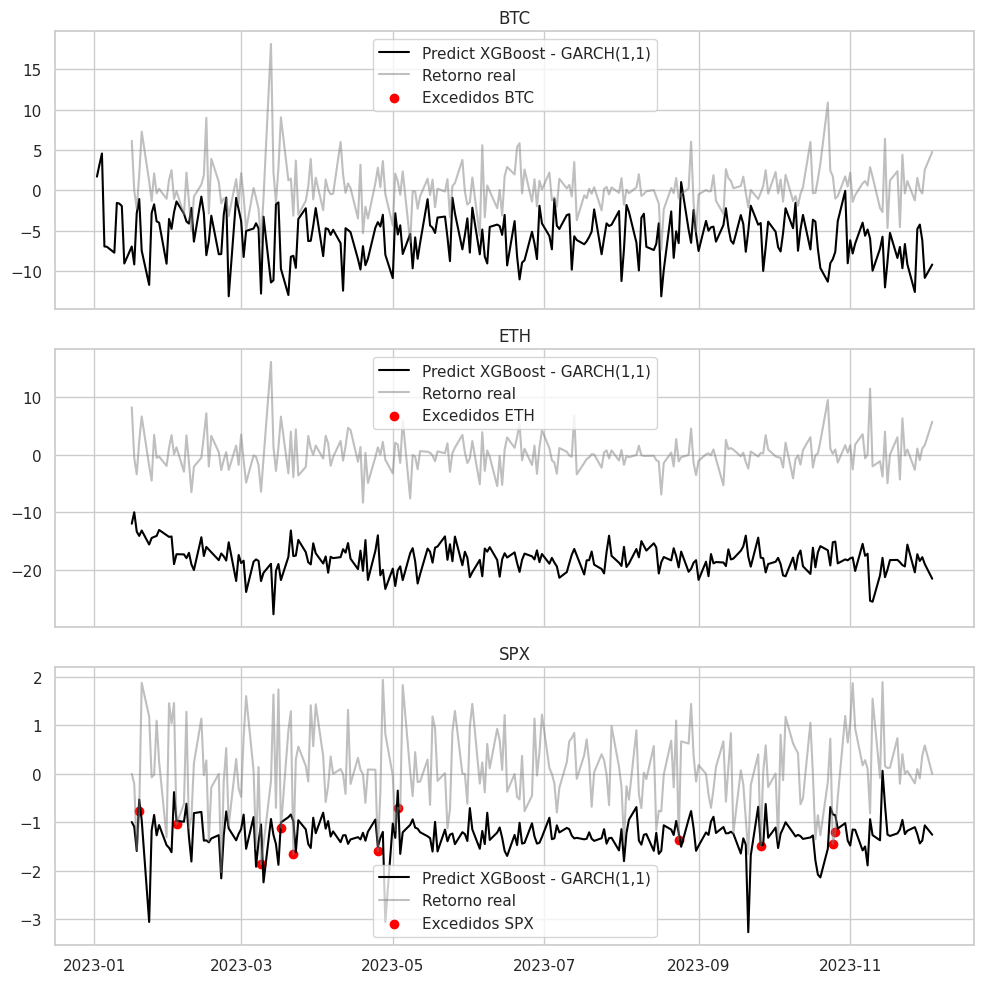

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Subplot 1: BTC
axs[0].plot(predictions_test_df.index, predictions_test_df['BTC_Predicted'], label='Predict XGBoost - GARCH(1,1)', color='black')
axs[0].plot(riesgo.index, riesgo['BTC_Actual'], label='Retorno real', color='gray', alpha=0.5)
axs[0].scatter(riesgo.index[riesgo['excedidos_BTC'] == 1], riesgo['BTC_Actual'][riesgo['excedidos_BTC'] == 1], color='red', label='Excedidos BTC')
axs[0].legend()
axs[0].set_title('BTC')

# Subplot 2: ETH
axs[1].plot(riesgo.index, riesgo['ETH'], label='Predict XGBoost - GARCH(1,1)', color='black')
axs[1].plot(riesgo.index, riesgo['ETH_Actual'], label='Retorno real', linestyle='-',  color='gray', alpha=0.5)
axs[1].scatter(riesgo.index[riesgo['excedidos_ETH'] == 1], riesgo['ETH_Actual'][riesgo['excedidos_ETH'] == 1], color='red', label='Excedidos ETH')
axs[1].set_title('ETH')
axs[1].legend()
# Subplot 3: SPX
axs[2].plot(riesgo.index, riesgo['SPX'], label='Predict XGBoost - GARCH(1,1)', color='Black')
axs[2].plot(riesgo.index, riesgo['SPX_Actual'], label='Retorno real', linestyle='-',  color='gray', alpha=0.5)
axs[2].scatter(riesgo.index[riesgo['excedidos_SPX'] == 1], riesgo['SPX_Actual'][riesgo['excedidos_SPX'] == 1], color='red', label='Excedidos SPX')
axs[2].set_title('SPX')

# Ajustes generales
plt.legend()
plt.tight_layout()
plt.show()
